In [68]:
!nvidia-smi

Mon Apr 26 20:51:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1C:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import sys
sys.path.append('../../')

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
from tqdm import tqdm
from typing import Tuple, List
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob 
from dateutil import parser
import dateutil
import transformers
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import re
import warnings
warnings.filterwarnings("ignore")
from scripts.get_train_test import normalize_target
from scripts.metrics import get_metrics, plot_two_distributions

In [40]:
def get_base_data():
    base_path = "../../data/Data DigitalFreud/final_data/"
    base_info_path = '1/item1.csv'

    base_info_file = os.path.join(base_path, base_info_path)
    base_info = pd.read_csv(base_info_file)
    base_info = base_info[(base_info.who_score.notna()) & (base_info.diener_score.notna())]
    return base_info

base_info = get_base_data()


In [41]:
base_info

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,13.0,3.0,5.0,5.0,3.0,6.0,13.0,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,1.0,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,1.0,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,15.0,5.0,5.0,5.0,5.0,5.0,10.0,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,3.0,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,1.0,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,2.0,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,10.0,5.0,2.0,2.0,5.0,5.0,16.0,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,19.0,5.0,4.0,5.0,5.0,5.0,11.0,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [42]:
def get_test_data():
    test_path = "../../data/Final-split-data/"
    test_info_path = 'test.csv'

    test_info_file = os.path.join(test_path, test_info_path)
    test_info = pd.read_csv(test_info_file)
    return test_info

test_data = get_test_data()

In [43]:
test_data

,vk_id_encrypted,DF_userid_encrypted,DF_who_score,DF_diener_score,gender_merged,age,DF_freud_install_time,PostNewest,PostOldest,Posts_-1,...,AppUsage18-21Ratio,AppUsage21-24Ratio,Positive_month,Negative_month,Positive_year,Negative_year,Positive_all,Negative_all,growth-2to-1,growth-2to-1weighted
0,124519629,ebfcf8a0-1660-25ef-764f-0943b2a3afd3,15.0,22.0,0,20,26.08.2018 23:16:04,28.12.2018 17:34,18.07.2017 18:39,1.0,...,0.180947,0.191729,0.009636,0.010633,0.010247,0.010427,0.010984,0.011534,-10019.0,-0.155882
1,149823476,72ba7693-8186-2c0e-79d4-464ef17082d9,12.0,18.0,0,24,30.06.2018 22:44:05,12.06.2018 12:07,13.01.2013 1:51,1.0,...,0.162728,0.033931,0.015812,0.008179,0.016299,0.011828,0.014857,0.012336,1046.0,0.066548
2,202020680,759c7f41-ba73-2de7-4a60-704fefecc966,6.0,5.0,0,19,23.09.2018 6:41:03,21.03.2019 13:37,21.03.2019 13:37,NaN,...,0.080756,0.081298,0.000000,0.006410,0.009754,0.018480,0.009754,0.018480,901.0,0.572063
3,293468270,0a6212e3-08d4-267c-5a00-275878d9ec4b,24.0,32.0,1,29,31.05.2018 0:43:03,25.04.2019 10:23,31.01.2008 10:28,NaN,...,0.097502,0.153691,0.013514,0.013514,0.007407,0.011523,0.010077,0.010275,-318.0,-0.148459
4,299001855,30793174-baba-257e-7710-75942cdc3620,19.0,20.0,0,21,27.06.2018 9:18:16,26.12.2017 19:54,16.05.2016 20:59,NaN,...,0.123882,0.236435,0.015712,0.008899,0.017580,0.008284,0.017284,0.010742,-349.0,-0.005487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,693337702,9c9c2af4-c8bf-21f8-7bc1-c469413ae886,20.0,26.0,0,19,2018-05-12 01:13:30,2019-06-15 20:08:48,2018-03-16 15:51:36,NaN,...,0.105421,0.206342,0.016143,0.013124,0.016297,0.014044,0.016297,0.014044,-69178.0,-0.174099
89,220279175,9d5d396b-6a7b-2503-7176-7babf75e10a2,13.0,15.0,0,22,2018-08-25 01:44:05,2019-07-13 08:59:28,2017-09-11 17:42:09,NaN,...,0.124529,0.178654,0.020799,0.012799,0.020038,0.013487,0.019147,0.013533,55357.0,0.234205
90,568464126,92e06d17-3c35-2611-509b-7b1c9f0e62b5,22.0,26.0,0,21,2018-08-14 02:36:17,2019-04-23 11:28:52,2016-04-05 19:19:10,NaN,...,0.117795,0.171572,0.014122,0.018553,0.014755,0.019320,0.014254,0.018508,-46370.0,-0.325769
91,815532206,97994d26-2a0a-27ba-5f98-fe79a260161d,24.0,20.0,1,23,2018-10-25 14:25:41,2019-05-05 18:05:51,2017-04-27 17:49:03,NaN,...,0.055088,0.261818,0.011022,0.004133,0.010163,0.005340,0.007798,0.005188,12509.0,0.495190


In [44]:
# rm users which are mentioned in test dataset

In [45]:
test_vk_ids = [str(i) for i in test_data.vk_id_encrypted.tolist()]

def rm_test_users(x):
    return str(x) in test_vk_ids

base_info['is_test_sample'] = base_info.vk_id_encrypted.apply(rm_test_users)
base_info_no_test = base_info[base_info.is_test_sample == False]

In [46]:
base_info_no_test = base_info_no_test[base_info_no_test.duplicated("vk_id_encrypted") == False]

In [47]:
base_info_no_test

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,...,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,is_test_sample
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,13.0,3.0,5.0,...,3.0,6.0,13.0,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08,False
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,...,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22,False
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,...,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11,False
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,15.0,5.0,5.0,...,5.0,5.0,10.0,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18,False
7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,23.0,4.0,4.0,...,1.0,1.0,24.0,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,...,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08,False
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,...,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00,False
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,10.0,5.0,2.0,...,5.0,5.0,16.0,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31,False
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,19.0,5.0,4.0,...,5.0,5.0,11.0,female,2000.0,other,unemployed,single,2019-03-27 11:48:09,False


In [48]:
files = glob("../../data/proc_messages-date-user2/texts/*")
files[:10]

['../../data/proc_messages-date-user2/texts/311226232.json.gz',
 '../../data/proc_messages-date-user2/texts/55106467.json.gz',
 '../../data/proc_messages-date-user2/texts/282720738.json.gz',
 '../../data/proc_messages-date-user2/texts/122949173.json.gz',
 '../../data/proc_messages-date-user2/texts/220419749.json.gz',
 '../../data/proc_messages-date-user2/texts/90175295.json.gz',
 '../../data/proc_messages-date-user2/texts/137479231.json.gz',
 '../../data/proc_messages-date-user2/texts/609145811.json.gz',
 '../../data/proc_messages-date-user2/texts/695942899.json.gz',
 '../../data/proc_messages-date-user2/texts/52851195.json.gz']

In [49]:
# prepare data: for each user get messages in interval [freud_install_time - 3 months; freud_install_time]

In [50]:
from tqdm import tqdm
import json

infos = list(zip(
    base_info_no_test.vk_id_encrypted.tolist(),
    base_info_no_test.freud_install_time.tolist(),
    base_info_no_test.who_score.tolist(),
    base_info_no_test.diener_score.tolist()
))


prepared_texts = [None] * len(infos)
index = -1
for vk_id, f_time, w_s, d_s in tqdm(infos):
    index +=1
    right_boundary = parser.parse(f_time)
    left_boundary = right_boundary - dateutil.relativedelta.relativedelta(**{"months": 3})
    texts_filtered_by_dates = []
    messages_file_path = f"../../data/proc_messages-date-user2/texts/{vk_id}.json.gz"
    try:
        with gzip.open(messages_file_path, 'r') as f_in:
            original_texts = json.load(f_in)
            for dialog in original_texts.values():
                for message, time in dialog:
                    t= parser.parse(time)
                    if left_boundary <= t <= right_boundary:
                        texts_filtered_by_dates.append((message, time))
            if texts_filtered_by_dates:
                prepared_texts[index] = texts_filtered_by_dates
   
    except Exception as e:
        continue


  1%|          | 7/1291 [00:05<17:03,  1.25it/s]


KeyboardInterrupt: 

In [14]:
prepared_texts[4:5]

[[('Привет', '2018-05-03 07:21:10'),
  ('Как ты?', '2018-05-03 07:24:52'),
  ('Не особо, хвосты намечаются, спать хочется', '2018-05-03 07:31:36'),
  ('Хм, по разному, от 30 до 120 минут)', '2018-05-03 07:43:40'),
  ('Ты в универе?', '2018-05-03 07:43:58'),
  ('Понятно, едешь?', '2018-05-03 07:47:25'),
  ('Сегодня же чв?', '2018-05-03 07:47:32'),
  ('Хорошо)', '2018-05-03 10:32:49'),
  ('Белая была', '2018-04-18 17:35:03'),
  ('Может, не чисто белая, может светло-серая', '2018-04-18 17:36:01'),
  ('Да?)', '2018-04-22 07:36:46'),
  ('Так, что за таблица?)', '2018-04-22 07:39:03'),
  ('По какому предмету?', '2018-04-22 07:41:09'),
  ('Ааа', '2018-04-22 07:41:36'),
  ('Возможно, этр результаты освоения', '2018-04-22 07:42:05'),
  ('Из программы дисциплины', '2018-04-22 07:42:37'),
  ('Хм.. Тогда либо где-то еще искаль, либо придумывать самим(',
   '2018-04-22 07:44:57'),
  ('Привет)', '2018-05-11 14:27:18'),
  ('Это по какому предмету? Который в пн или вт?', '2018-05-12 18:18:34'),
  ('Я 

In [41]:
base_info_no_test["3_months_text"] = prepared_texts

In [26]:
# #base_info_no_test.to_csv("./base_users_3_months_text_no_tests.csv", sep="±")

In [51]:
import sys
import csv
# technical limits
csv.field_size_limit(sys.maxsize)

9223372036854775807

In [52]:
from scripts.get_train_test import normalize_target
base_info_no_test = pd.read_csv("./base_users_3_months_text_no_tests.csv", sep="±")

In [53]:
sample = normalize_target(base_info_no_test, who_score="who_score", diener_score="diener_score")

In [54]:
sample

,Unnamed: 0,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,...,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,is_test_sample,3_months_text
0,0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,0.32,3.0,...,6.0,0.266667,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08,False,NaN
1,1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,0.44,6.0,...,5.0,0.466667,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22,False,[]
2,2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,0.36,2.0,...,4.0,0.666667,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11,False,[]
3,3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,0.40,5.0,...,5.0,0.166667,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18,False,NaN
4,7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,0.72,4.0,...,1.0,0.633333,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,False,"['Привет', 'Как ты?', 'Не особо, хвосты намеча..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,0.44,5.0,...,4.0,0.333333,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08,False,"['Настя, на всякий случай, если ещё не в курсе..."
1287,2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,0.40,3.0,...,4.0,0.533333,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00,False,"['какие интересные боты в комментах обитают', ..."
1288,2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,0.20,5.0,...,5.0,0.366667,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31,False,NaN
1289,2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,0.56,5.0,...,5.0,0.200000,female,2000.0,other,unemployed,single,2019-03-27 11:48:09,False,NaN


In [55]:
# delete all users with no messages

In [56]:
sample = sample[sample["3_months_text"].notna()]
sample

,Unnamed: 0,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,...,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,is_test_sample,3_months_text
1,1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,0.44,6.0,...,5.0,0.466667,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22,False,[]
2,2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,0.36,2.0,...,4.0,0.666667,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11,False,[]
4,7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,0.72,4.0,...,1.0,0.633333,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,False,"['Привет', 'Как ты?', 'Не особо, хвосты намеча..."
6,10,fb783013-040a-2481-7174-3bf9e0549c29,200269216,4.0,4.0,4.0,5.0,3.0,0.20,6.0,...,6.0,0.133333,female,1994.0,"Магистр, сейчас не учусь",NaN,NaN,2018-08-28 13:33:33,False,"['О, спасибо огромное) мне очень приятно что в..."
7,11,fb5ca4c8-b228-2a8e-7489-c8bc9a82e057,305836538,4.0,4.0,4.0,5.0,3.0,0.20,5.0,...,4.0,0.333333,NaN,NaN,NaN,NaN,NaN,2018-07-21 22:51:49,False,"['У меня как то наоборот', 'У меня', 'Выскочил..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,2032,051b5d08-a4da-2c2e-7139-5c021ce05d4a,540669219,2.0,4.0,2.0,4.0,5.0,0.32,4.0,...,6.0,0.366667,NaN,NaN,NaN,NaN,NaN,2018-03-29 10:04:57,False,"['Немного', '4', 'Я в курилке уже стою', 'Что ..."
1285,2033,0574c52f-84d4-21b1-5447-03f1559a655f,354174379,2.0,1.0,2.0,3.0,0.0,0.68,2.0,...,5.0,0.466667,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-30 09:03:00,False,"['хм, хотела в группу, но вышло персонально', ..."
1286,2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,0.44,5.0,...,4.0,0.333333,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08,False,"['Настя, на всякий случай, если ещё не в курсе..."
1287,2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,0.40,3.0,...,4.0,0.533333,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00,False,"['какие интересные боты в комментах обитают', ..."


In [57]:
def replace_empty(x):
    x = eval(x)
    if isinstance(x, list) and len(x) == 0:
        return np.nan
    else:
        return x
    
sample["3_months_text"] = sample["3_months_text"].apply(replace_empty)

In [58]:
base_info_no_test_drop = sample[sample["3_months_text"].notna()]

In [59]:
base_info_no_test_drop

,Unnamed: 0,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,...,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,is_test_sample,3_months_text
4,7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,0.72,4.0,...,1.0,0.633333,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,False,"[Привет, Как ты?, Не особо, хвосты намечаются,..."
6,10,fb783013-040a-2481-7174-3bf9e0549c29,200269216,4.0,4.0,4.0,5.0,3.0,0.20,6.0,...,6.0,0.133333,female,1994.0,"Магистр, сейчас не учусь",NaN,NaN,2018-08-28 13:33:33,False,"[О, спасибо огромное) мне очень приятно что вы..."
7,11,fb5ca4c8-b228-2a8e-7489-c8bc9a82e057,305836538,4.0,4.0,4.0,5.0,3.0,0.20,5.0,...,4.0,0.333333,NaN,NaN,NaN,NaN,NaN,2018-07-21 22:51:49,False,"[У меня как то наоборот, У меня, Выскочил, ПРЫ..."
13,18,f8326bdb-ea08-2293-58a1-a15ddffee26e,313691105,3.0,3.0,3.0,3.0,4.0,0.36,4.0,...,5.0,0.266667,female,1995.0,"Неоконченное высшее, учусь",NaN,NaN,2018-07-31 10:25:13,False,"[Нашивки еще не делала, но пару раз вышивала н..."
14,20,f847716f-d93d-2ff2-6328-513abb5d302f,101806588,2.0,3.0,3.0,2.0,1.0,0.56,5.0,...,5.0,0.266667,NaN,NaN,NaN,NaN,NaN,2018-04-03 21:38:26,False,"[Ты ко скольки пойдёшь?, Дома, А Никитин, Пойд..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,2032,051b5d08-a4da-2c2e-7139-5c021ce05d4a,540669219,2.0,4.0,2.0,4.0,5.0,0.32,4.0,...,6.0,0.366667,NaN,NaN,NaN,NaN,NaN,2018-03-29 10:04:57,False,"[Немного, 4, Я в курилке уже стою, Что творишь..."
1285,2033,0574c52f-84d4-21b1-5447-03f1559a655f,354174379,2.0,1.0,2.0,3.0,0.0,0.68,2.0,...,5.0,0.466667,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-30 09:03:00,False,"[хм, хотела в группу, но вышло персонально, оу..."
1286,2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,0.44,5.0,...,4.0,0.333333,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08,False,"[Настя, на всякий случай, если ещё не в курсе,..."
1287,2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,0.40,3.0,...,4.0,0.533333,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00,False,"[какие интересные боты в комментах обитают, да..."


In [60]:
# each user described by a long text which is a sum of all his messages

In [61]:
def concat_text(x):
    return " ".join([str(i) for i in x])

base_info_no_test_drop["text_by_user"] = base_info_no_test_drop["3_months_text"].apply(concat_text)

base_info_no_test_drop

,Unnamed: 0,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,...,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,is_test_sample,3_months_text,text_by_user
4,7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,0.72,4.0,...,0.633333,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,False,"[Привет, Как ты?, Не особо, хвосты намечаются,...","Привет Как ты? Не особо, хвосты намечаются, сп..."
6,10,fb783013-040a-2481-7174-3bf9e0549c29,200269216,4.0,4.0,4.0,5.0,3.0,0.20,6.0,...,0.133333,female,1994.0,"Магистр, сейчас не учусь",NaN,NaN,2018-08-28 13:33:33,False,"[О, спасибо огромное) мне очень приятно что вы...","О, спасибо огромное) мне очень приятно что вы ..."
7,11,fb5ca4c8-b228-2a8e-7489-c8bc9a82e057,305836538,4.0,4.0,4.0,5.0,3.0,0.20,5.0,...,0.333333,NaN,NaN,NaN,NaN,NaN,2018-07-21 22:51:49,False,"[У меня как то наоборот, У меня, Выскочил, ПРЫ...",У меня как то наоборот У меня Выскочил ПРЫЩ Пр...
13,18,f8326bdb-ea08-2293-58a1-a15ddffee26e,313691105,3.0,3.0,3.0,3.0,4.0,0.36,4.0,...,0.266667,female,1995.0,"Неоконченное высшее, учусь",NaN,NaN,2018-07-31 10:25:13,False,"[Нашивки еще не делала, но пару раз вышивала н...","Нашивки еще не делала, но пару раз вышивала на..."
14,20,f847716f-d93d-2ff2-6328-513abb5d302f,101806588,2.0,3.0,3.0,2.0,1.0,0.56,5.0,...,0.266667,NaN,NaN,NaN,NaN,NaN,2018-04-03 21:38:26,False,"[Ты ко скольки пойдёшь?, Дома, А Никитин, Пойд...",Ты ко скольки пойдёшь? Дома А Никитин Пойду Ок...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,2032,051b5d08-a4da-2c2e-7139-5c021ce05d4a,540669219,2.0,4.0,2.0,4.0,5.0,0.32,4.0,...,0.366667,NaN,NaN,NaN,NaN,NaN,2018-03-29 10:04:57,False,"[Немного, 4, Я в курилке уже стою, Что творишь...",Немного 4 Я в курилке уже стою Что творишь? Ау...
1285,2033,0574c52f-84d4-21b1-5447-03f1559a655f,354174379,2.0,1.0,2.0,3.0,0.0,0.68,2.0,...,0.466667,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-30 09:03:00,False,"[хм, хотела в группу, но вышло персонально, оу...","хм, хотела в группу, но вышло персонально оу а..."
1286,2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,0.44,5.0,...,0.333333,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08,False,"[Настя, на всякий случай, если ещё не в курсе,...","Настя, на всякий случай, если ещё не в курсе, ..."
1287,2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,0.40,3.0,...,0.533333,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00,False,"[какие интересные боты в комментах обитают, да...",какие интересные боты в комментах обитают да н...


In [ ]:
# only russian words, no punctuation, no emoji - enough data to setup experiment only with lexical info 

In [123]:
import re
def clear_text(x):
    x = x.lower()
    words = re.findall('[а-яё]+',x)
    return " ".join(words)
    
base_info_no_test_drop["clear_text_by_user"] = base_info_no_test_drop["text_by_user"].apply(clear_text)

In [124]:
base_info_no_test_drop.head()

,Unnamed: 0,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,...,sex,birthyear,education,employment,marital_status,freud_install_time,is_test_sample,3_months_text,text_by_user,clear_text_by_user
4,7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,0.72,4.0,...,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,False,"[Привет, Как ты?, Не особо, хвосты намечаются,...","Привет Как ты? Не особо, хвосты намечаются, сп...",привет как ты не особо хвосты намечаются спать...
6,10,fb783013-040a-2481-7174-3bf9e0549c29,200269216,4.0,4.0,4.0,5.0,3.0,0.20,6.0,...,female,1994.0,"Магистр, сейчас не учусь",NaN,NaN,2018-08-28 13:33:33,False,"[О, спасибо огромное) мне очень приятно что вы...","О, спасибо огромное) мне очень приятно что вы ...",о спасибо огромное мне очень приятно что вы пр...
7,11,fb5ca4c8-b228-2a8e-7489-c8bc9a82e057,305836538,4.0,4.0,4.0,5.0,3.0,0.20,5.0,...,NaN,NaN,NaN,NaN,NaN,2018-07-21 22:51:49,False,"[У меня как то наоборот, У меня, Выскочил, ПРЫ...",У меня как то наоборот У меня Выскочил ПРЫЩ Пр...,у меня как то наоборот у меня выскочил прыщ пр...
13,18,f8326bdb-ea08-2293-58a1-a15ddffee26e,313691105,3.0,3.0,3.0,3.0,4.0,0.36,4.0,...,female,1995.0,"Неоконченное высшее, учусь",NaN,NaN,2018-07-31 10:25:13,False,"[Нашивки еще не делала, но пару раз вышивала н...","Нашивки еще не делала, но пару раз вышивала на...",нашивки еще не делала но пару раз вышивала на ...
14,20,f847716f-d93d-2ff2-6328-513abb5d302f,101806588,2.0,3.0,3.0,2.0,1.0,0.56,5.0,...,NaN,NaN,NaN,NaN,NaN,2018-04-03 21:38:26,False,"[Ты ко скольки пойдёшь?, Дома, А Никитин, Пойд...",Ты ко скольки пойдёшь? Дома А Никитин Пойду Ок...,ты ко скольки пойдёшь дома а никитин пойду ок ...


In [1]:
# simple spliting

In [125]:
n_samples = 450
train = base_info_no_test_drop[:n_samples]
test = base_info_no_test_drop[n_samples:]

TRAIN


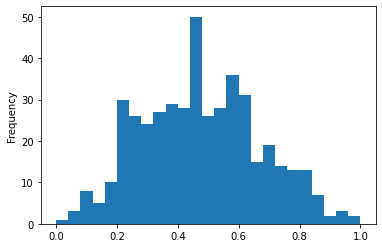

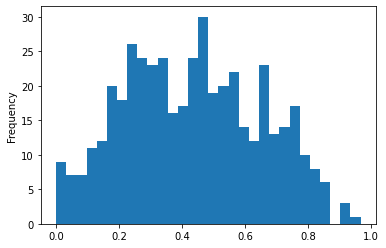

TEST


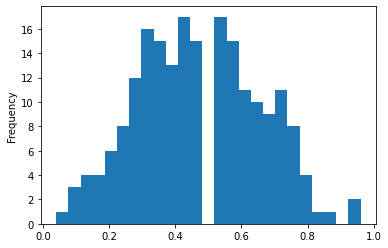

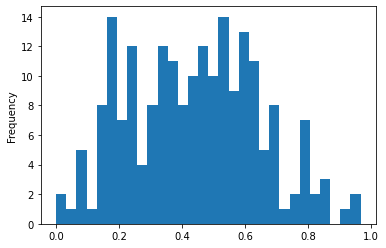

In [126]:
import matplotlib.pyplot as plt
print("TRAIN")
train.who_score.plot.hist(bins=25)
plt.show()
train.diener_score.plot.hist(bins=30)
plt.show()
print("TEST")
test.who_score.plot.hist(bins=25)
plt.show()
test.diener_score.plot.hist(bins=30)
plt.show()

In [127]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
import numpy as np
import json
import random

In [128]:
stop_words = """
и
в
во
не
что
он
на
я
с
со
как
а
то
все
она
так
его
но
да
ты
к
у
же
вы
за
бы
по
только
ее
мне
было
вот
от
меня
еще
нет
о
из
ему
теперь
когда
даже
ну
вдруг
ли
если
уже
или
ни
быть
был
него
до
вас
нибудь
опять
уж
вам
сказал
ведь
там
потом
себя
ничего
ей
может
они
тут
где
есть
надо
ней
для
мы
тебя
их
чем
была
сам
чтоб
без
будто
человек
чего
раз
тоже
себе
под
жизнь
будет
ж
тогда
кто
этот
говорил
того
потому
этого
какой
совсем
ним
здесь
этом
один
почти
мой
тем
чтобы
нее
кажется
сейчас
были
куда
зачем
сказать
всех
никогда
сегодня
можно
при
наконец
два
об
другой
хоть
после
над
больше
тот
через
эти
нас
про
всего
них
какая
много
разве
сказала
три
эту
моя
впрочем
хорошо
свою
этой
перед
иногда
лучше
чуть
том
нельзя
такой
им
более
всегда
конечно
всю
между"""
stop_words = [i for i in stop_words.split("\n") if i.strip()]
stop_words[:3]

['и', 'в', 'во']

# Simple Topic Modeling
stop words are not used

In [137]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=5, ngram_range=(1, 1), stop_words = stop_words
)
tf = tf_vectorizer.fit_transform(train["clear_text_by_user"])

In [138]:
tf.shape

(450, 58868)

In [141]:
nmf = NMF(n_components=40, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tf)

In [142]:
def get_model_topics(model, vectorizer, topics, n_top_words=50):
    word_dict = {}
    word_dict_indicies = {}
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        word_dict[topics[topic_idx]] = top_features
        word_dict_indicies[topics[topic_idx]] = top_features_ind

    return pd.DataFrame(word_dict), word_dict_indicies

words, indicies = get_model_topics(nmf, tf_vectorizer, [f"topic_#{i}" for i in range(50)])

In [143]:
words[:30]

,topic_#0,topic_#1,topic_#2,topic_#3,topic_#4,topic_#5,topic_#6,topic_#7,topic_#8,topic_#9,...,topic_#30,topic_#31,topic_#32,topic_#33,topic_#34,topic_#35,topic_#36,topic_#37,topic_#38,topic_#39
0,это,хд,че,блин,просто,всё,плачет,бля,просто,бля,...,шо,тебе,щас,это,это,типа,это,это,чё,это
1,вообще,это,блять,это,очень,очень,довольно,ещё,блять,очень,...,та,дурак,это,очень,всё,просто,господи,спать,че,просто
2,почему,хдд,пиздец,просто,знаю,просто,обнимает,чо,тебе,это,...,владос,знаю,норм,блин,бля,это,спасибо,почему,завтра,ща
3,такое,просто,бля,поняла,могу,ещё,крепко,это,бля,блять,...,блин,мм,типа,типо,просто,ахаха,просто,привет,хз,ору
4,тебе,ибо,это,чё,пока,это,это,ля,хочу,че,...,завтра,та,просто,ладно,кстати,очень,женя,знаю,норм,такая
5,хотя,бля,нахуй,ток,немного,тебе,стонет,просто,люблю,ору,...,бля,это,вообще,бля,вроде,тт,почему,доброй,ага,чет
6,делать,хддд,сука,знаю,вроде,кстати,улыбнулся,ааааааааааааааа,буду,пиздец,...,хочу,угу,хочу,просто,вообще,думаю,блять,доброе,давай,настя
7,время,хочу,щас,понимаю,хочу,хд,смотрит,вообще,это,просто,...,чо,ник,завтра,вообще,тебе,наверное,воу,ладно,тебе,прям
8,очень,такое,лол,тебе,думаю,хочу,всё,ща,чё,сука,...,мя,просто,хз,короче,типа,могу,тебе,ночи,просто,тебе
9,знаешь,вроде,ваще,ага,завтра,знаю,брата,очень,ебать,лол,...,че,ладно,вроде,ок,буду,вообще,ох,утро,это,буду


In [ ]:
# it is needed to agregate some tokens like [["axaxaxa", "axax", "pxaxa"], ["aaaaaa", "aaa"]]

## Using only 50 first words from NMF, try to find correlections 
limitations of this approach is a quality of topics, this decompotion is not good, beacuse as it is shown in table above - words are repeated  between topics

TOPIC_#0
Report:
mean_squared_error: 0.0475
mean_absolute_error: 0.1812
r2_score -0.0395
pearsonr_corr: 0.0858, pearsonr_p: 0.2238
spearman_corr: 0.0725, spearman_p: 0.3039



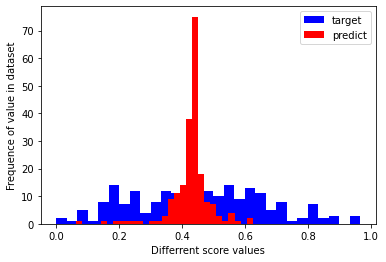

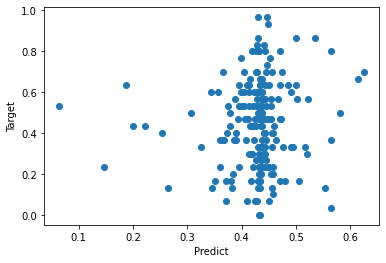

TOPIC_#1
Report:
mean_squared_error: 0.048
mean_absolute_error: 0.1828
r2_score -0.051
pearsonr_corr: 0.0642, pearsonr_p: 0.3631
spearman_corr: -0.0022, spearman_p: 0.9748



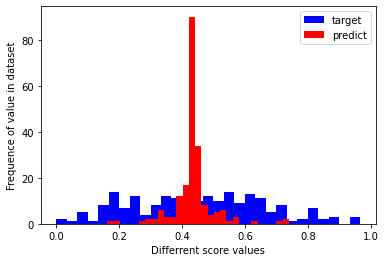

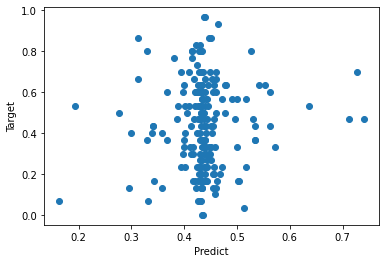

TOPIC_#2
Report:
mean_squared_error: 0.0497
mean_absolute_error: 0.186
r2_score -0.0879
pearsonr_corr: 0.0142, pearsonr_p: 0.8404
spearman_corr: -0.0137, spearman_p: 0.8457



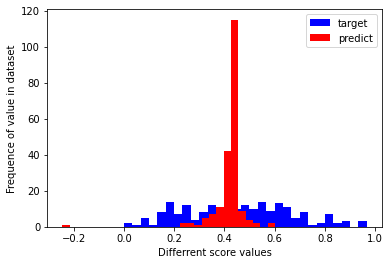

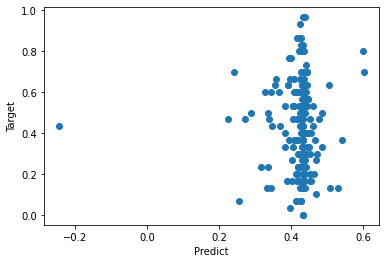

TOPIC_#3
Report:
mean_squared_error: 0.0513
mean_absolute_error: 0.1845
r2_score -0.1235
pearsonr_corr: -0.0318, pearsonr_p: 0.6526
spearman_corr: 0.0462, spearman_p: 0.5128



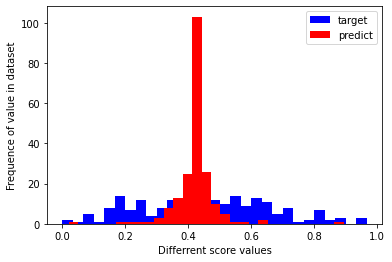

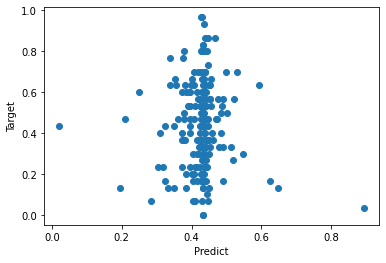

TOPIC_#4
Report:
mean_squared_error: 0.0443
mean_absolute_error: 0.1759
r2_score 0.0296
pearsonr_corr: 0.1981, pearsonr_p: 0.0046
spearman_corr: 0.1568, spearman_p: 0.0255



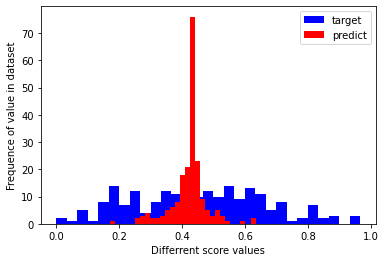

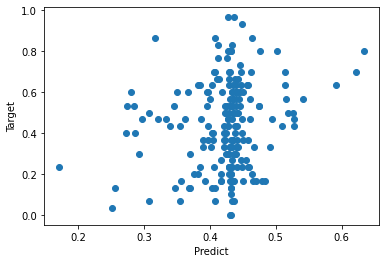

TOPIC_#5
Report:
mean_squared_error: 0.0463
mean_absolute_error: 0.1779
r2_score -0.0133
pearsonr_corr: 0.148, pearsonr_p: 0.0351
spearman_corr: 0.1764, spearman_p: 0.0118



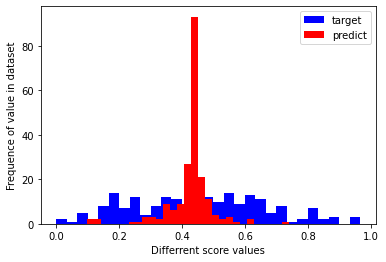

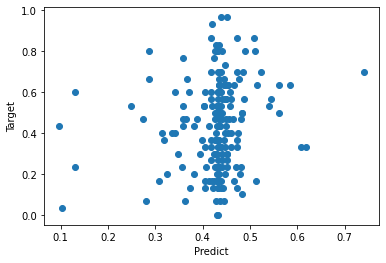

TOPIC_#6
Report:
mean_squared_error: 0.0505
mean_absolute_error: 0.1857
r2_score -0.1053
pearsonr_corr: -0.0443, pearsonr_p: 0.5305
spearman_corr: -0.0117, spearman_p: 0.8682



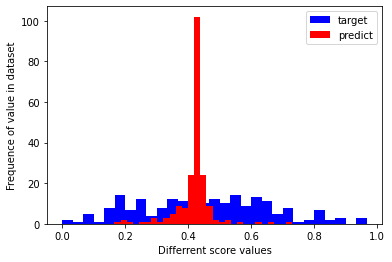

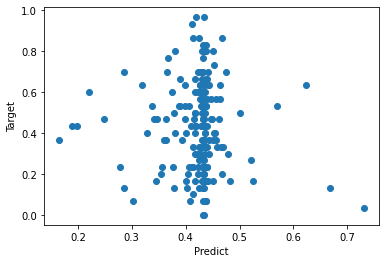

TOPIC_#7
Report:
mean_squared_error: 0.0499
mean_absolute_error: 0.1855
r2_score -0.0913
pearsonr_corr: 0.0013, pearsonr_p: 0.9858
spearman_corr: -0.0271, spearman_p: 0.7013



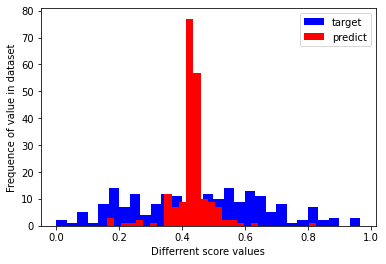

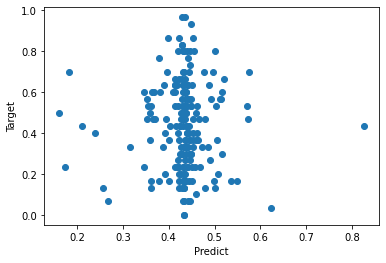

TOPIC_#8
Report:
mean_squared_error: 0.0515
mean_absolute_error: 0.1841
r2_score -0.1264
pearsonr_corr: -0.0195, pearsonr_p: 0.7823
spearman_corr: 0.1306, spearman_p: 0.0632



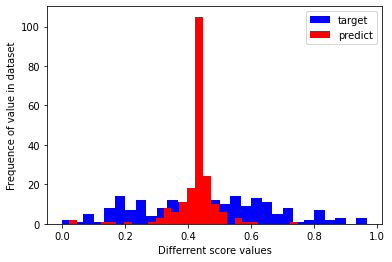

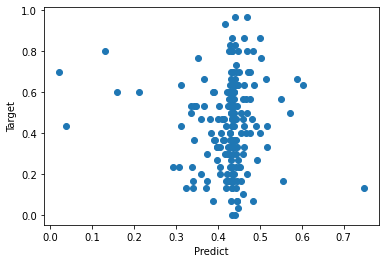

TOPIC_#9
Report:
mean_squared_error: 0.0528
mean_absolute_error: 0.1891
r2_score -0.1559
pearsonr_corr: -0.0088, pearsonr_p: 0.9007
spearman_corr: 0.0578, spearman_p: 0.4127



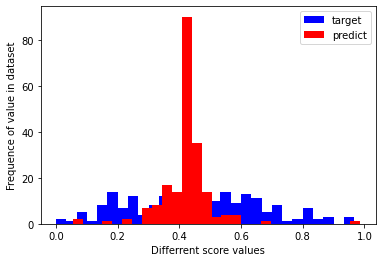

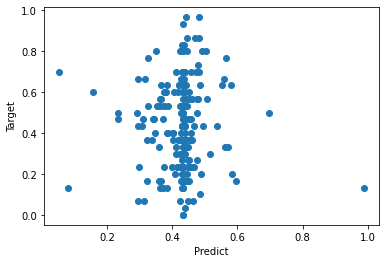

TOPIC_#10
Report:
mean_squared_error: 0.0452
mean_absolute_error: 0.1765
r2_score 0.0105
pearsonr_corr: 0.1577, pearsonr_p: 0.0246
spearman_corr: 0.0802, spearman_p: 0.2554



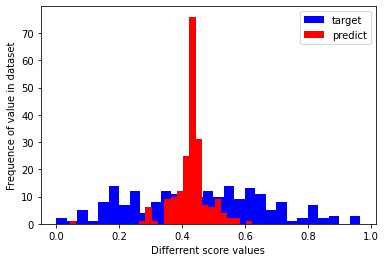

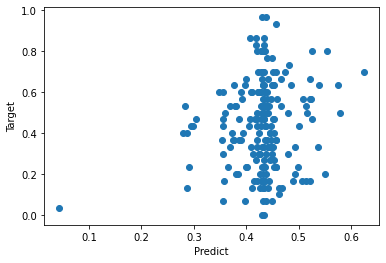

TOPIC_#11
Report:
mean_squared_error: 0.0468
mean_absolute_error: 0.1796
r2_score -0.023
pearsonr_corr: 0.1101, pearsonr_p: 0.118
spearman_corr: 0.0671, spearman_p: 0.3411



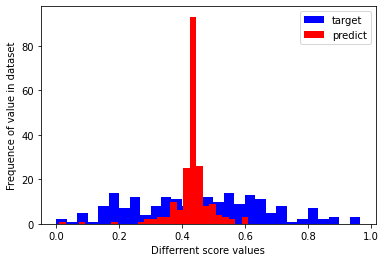

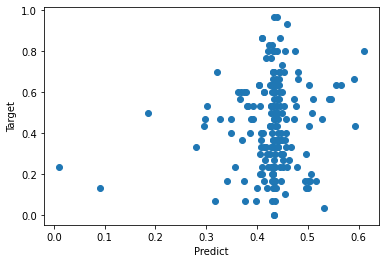

TOPIC_#12
Report:
mean_squared_error: 0.0464
mean_absolute_error: 0.178
r2_score -0.0163
pearsonr_corr: 0.1447, pearsonr_p: 0.0394
spearman_corr: 0.0884, spearman_p: 0.2096



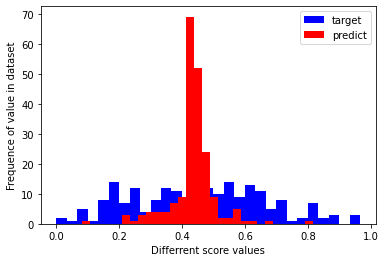

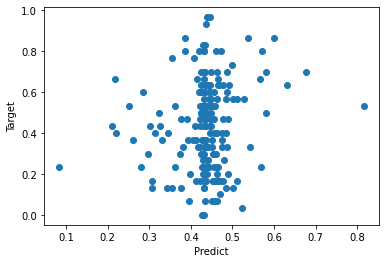

TOPIC_#13
Report:
mean_squared_error: 0.0508
mean_absolute_error: 0.1868
r2_score -0.1113
pearsonr_corr: -0.0611, pearsonr_p: 0.3867
spearman_corr: -0.0728, spearman_p: 0.3021



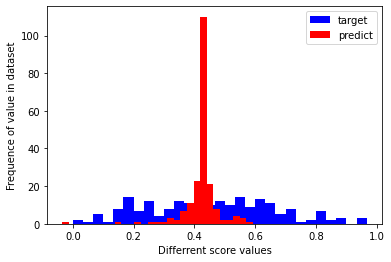

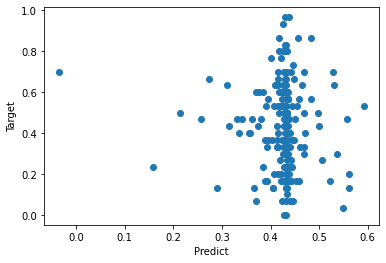

TOPIC_#14
Report:
mean_squared_error: 0.0533
mean_absolute_error: 0.1921
r2_score -0.1671
pearsonr_corr: 0.0309, pearsonr_p: 0.662
spearman_corr: 0.0181, spearman_p: 0.7977



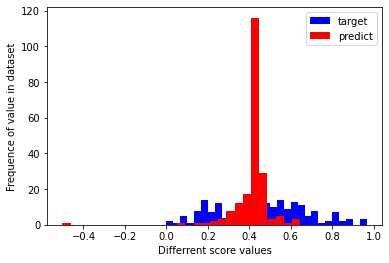

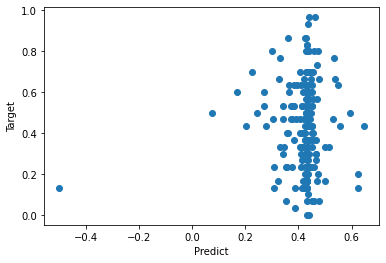

TOPIC_#15
Report:
mean_squared_error: 0.0485
mean_absolute_error: 0.1817
r2_score -0.0617
pearsonr_corr: 0.0494, pearsonr_p: 0.4843
spearman_corr: 0.0101, spearman_p: 0.8867



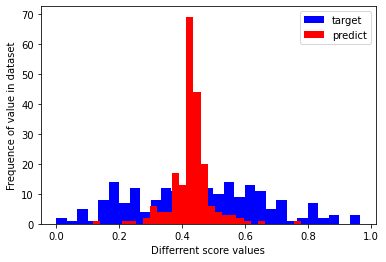

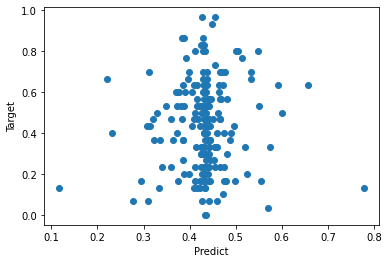

TOPIC_#16
Report:
mean_squared_error: 0.047
mean_absolute_error: 0.1799
r2_score -0.0283
pearsonr_corr: 0.0741, pearsonr_p: 0.2931
spearman_corr: 0.095, spearman_p: 0.1776



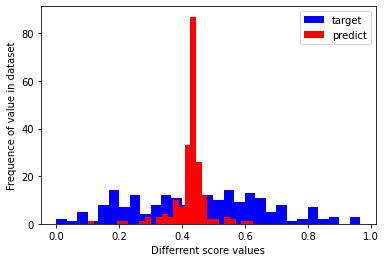

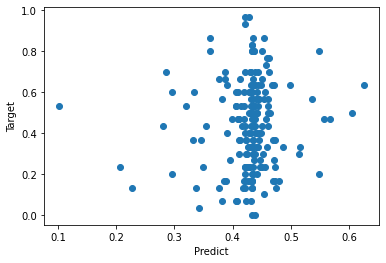

TOPIC_#17
Report:
mean_squared_error: 0.0486
mean_absolute_error: 0.1821
r2_score -0.064
pearsonr_corr: 0.0609, pearsonr_p: 0.3883
spearman_corr: 0.0361, spearman_p: 0.6088



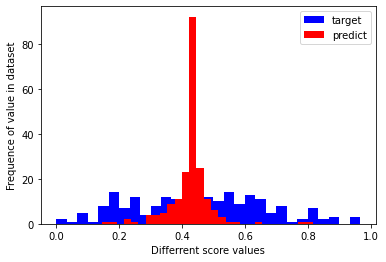

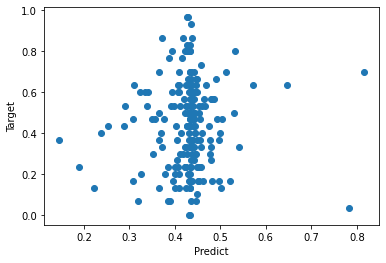

TOPIC_#18
Report:
mean_squared_error: 0.0516
mean_absolute_error: 0.1886
r2_score -0.1285
pearsonr_corr: 0.0342, pearsonr_p: 0.6276
spearman_corr: 0.0748, spearman_p: 0.2888



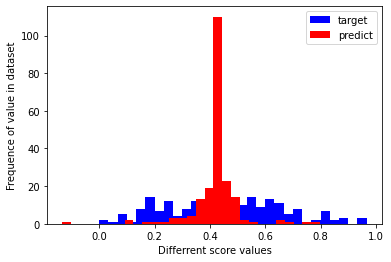

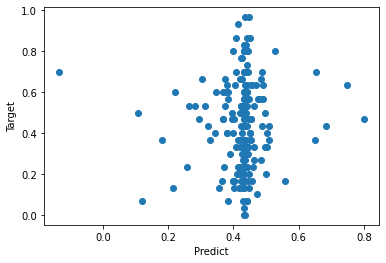

TOPIC_#19
Report:
mean_squared_error: 0.0522
mean_absolute_error: 0.1889
r2_score -0.1417
pearsonr_corr: 0.0679, pearsonr_p: 0.3356
spearman_corr: 0.0681, spearman_p: 0.3347



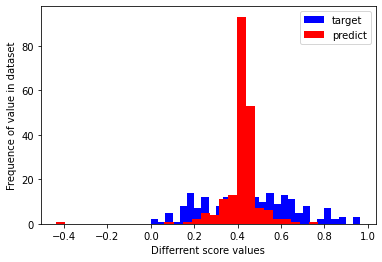

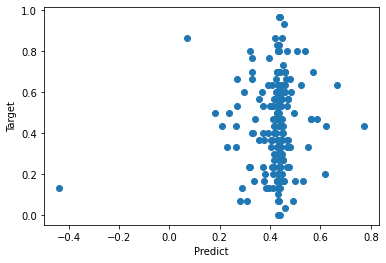

TOPIC_#20
Report:
mean_squared_error: 0.0526
mean_absolute_error: 0.189
r2_score -0.1519
pearsonr_corr: -0.014, pearsonr_p: 0.8424
spearman_corr: 0.0442, spearman_p: 0.5313



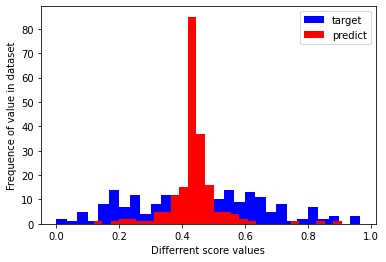

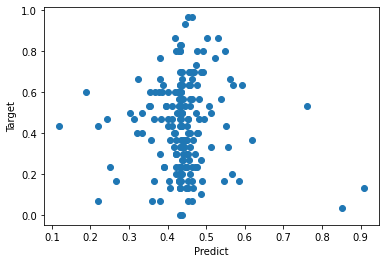

TOPIC_#21
Report:
mean_squared_error: 0.0442
mean_absolute_error: 0.176
r2_score 0.0319
pearsonr_corr: 0.1922, pearsonr_p: 0.006
spearman_corr: 0.0952, spearman_p: 0.1767



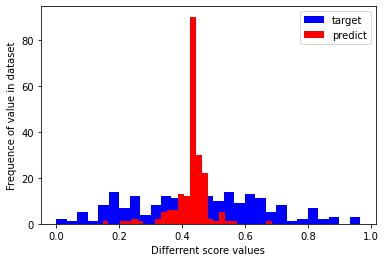

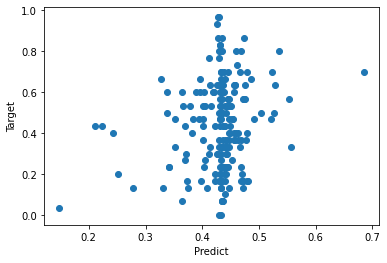

TOPIC_#22
Report:
mean_squared_error: 0.0475
mean_absolute_error: 0.1804
r2_score -0.0398
pearsonr_corr: 0.0621, pearsonr_p: 0.3788
spearman_corr: 0.0418, spearman_p: 0.5534



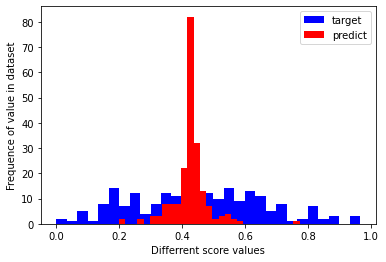

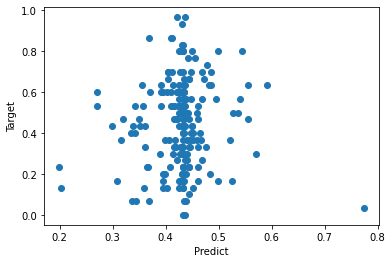

TOPIC_#23
Report:
mean_squared_error: 0.0462
mean_absolute_error: 0.1771
r2_score -0.0102
pearsonr_corr: 0.1091, pearsonr_p: 0.1213
spearman_corr: 0.144, spearman_p: 0.0403



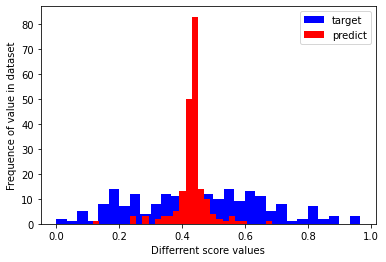

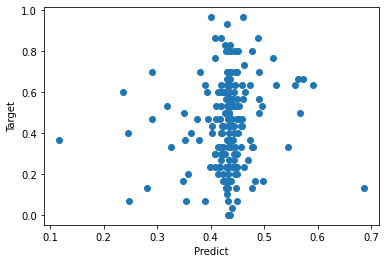

TOPIC_#24
Report:
mean_squared_error: 0.0487
mean_absolute_error: 0.1838
r2_score -0.0651
pearsonr_corr: 0.0757, pearsonr_p: 0.2831
spearman_corr: 0.0391, spearman_p: 0.5793



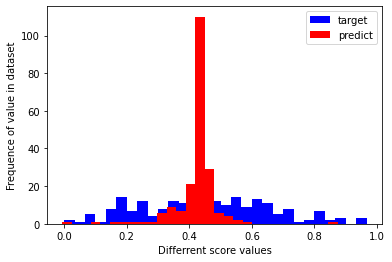

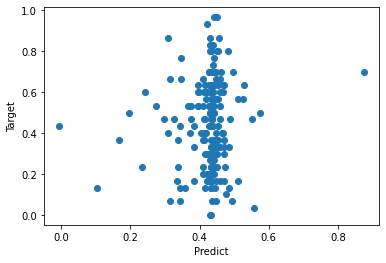

TOPIC_#25
Report:
mean_squared_error: 0.0466
mean_absolute_error: 0.1801
r2_score -0.0206
pearsonr_corr: 0.1073, pearsonr_p: 0.1274
spearman_corr: 0.075, spearman_p: 0.2876



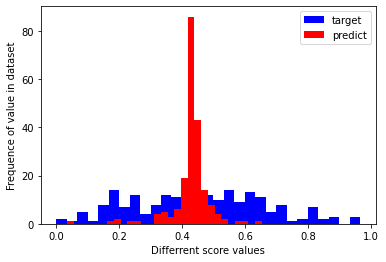

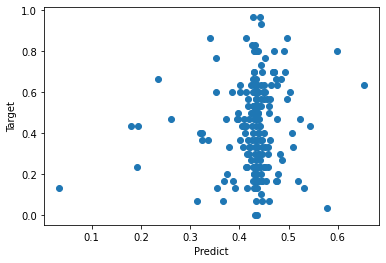

TOPIC_#26
Report:
mean_squared_error: 0.043
mean_absolute_error: 0.173
r2_score 0.0593
pearsonr_corr: 0.2447, pearsonr_p: 0.0004
spearman_corr: 0.2804, spearman_p: 0.0001



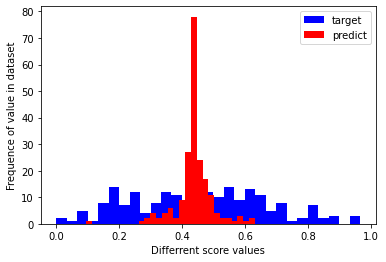

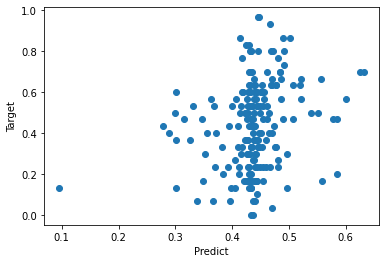

TOPIC_#27
Report:
mean_squared_error: 0.0486
mean_absolute_error: 0.1832
r2_score -0.0626
pearsonr_corr: 0.0285, pearsonr_p: 0.6867
spearman_corr: 0.1102, spearman_p: 0.1177



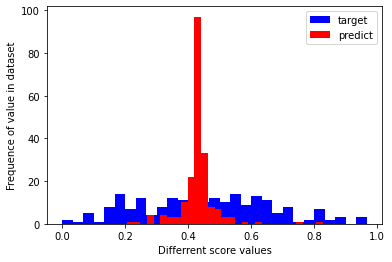

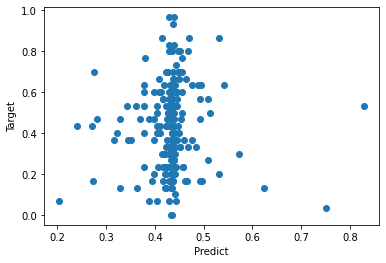

TOPIC_#28
Report:
mean_squared_error: 0.0516
mean_absolute_error: 0.1867
r2_score -0.1301
pearsonr_corr: 0.0659, pearsonr_p: 0.3499
spearman_corr: 0.0532, spearman_p: 0.4512



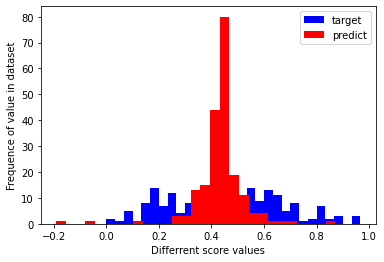

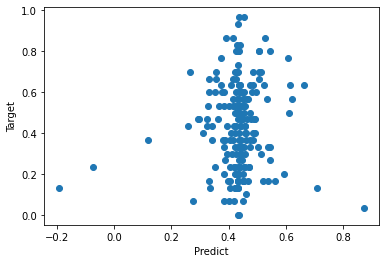

TOPIC_#29
Report:
mean_squared_error: 0.0494
mean_absolute_error: 0.1842
r2_score -0.081
pearsonr_corr: 0.0693, pearsonr_p: 0.326
spearman_corr: 0.0408, spearman_p: 0.563



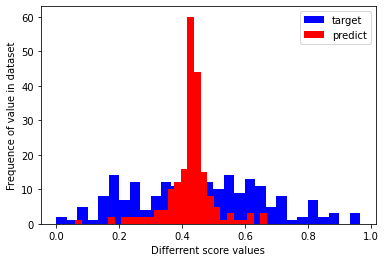

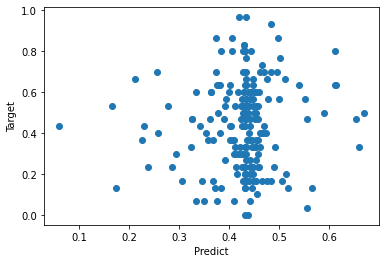

TOPIC_#30
Report:
mean_squared_error: 0.0479
mean_absolute_error: 0.179
r2_score -0.0472
pearsonr_corr: 0.1029, pearsonr_p: 0.1438
spearman_corr: 0.0574, spearman_p: 0.4163



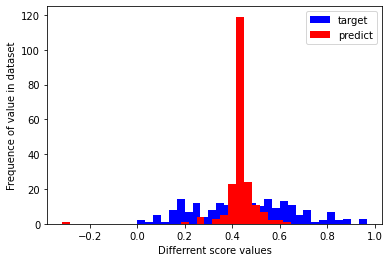

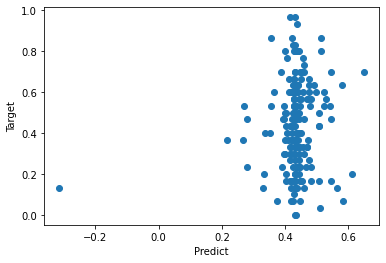

TOPIC_#31
Report:
mean_squared_error: 0.0524
mean_absolute_error: 0.1848
r2_score -0.1464
pearsonr_corr: 0.0153, pearsonr_p: 0.8283
spearman_corr: 0.0364, spearman_p: 0.6063



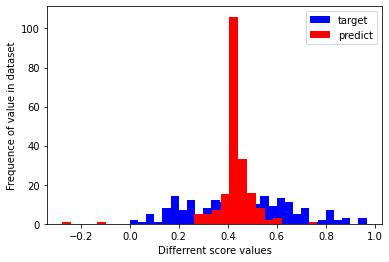

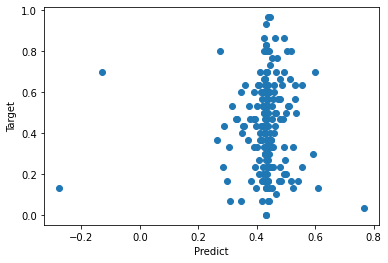

TOPIC_#32
Report:
mean_squared_error: 0.0456
mean_absolute_error: 0.1765
r2_score 0.0013
pearsonr_corr: 0.1355, pearsonr_p: 0.0539
spearman_corr: 0.0627, spearman_p: 0.3738



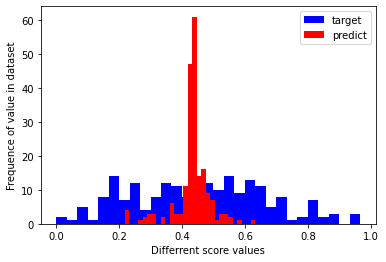

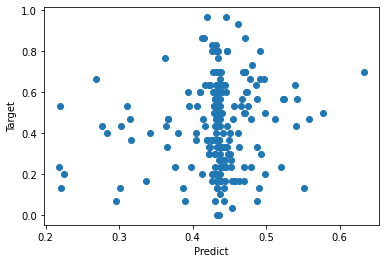

TOPIC_#33
Report:
mean_squared_error: 0.0604
mean_absolute_error: 0.1968
r2_score -0.3219
pearsonr_corr: -0.1232, pearsonr_p: 0.0799
spearman_corr: -0.0585, spearman_p: 0.4075



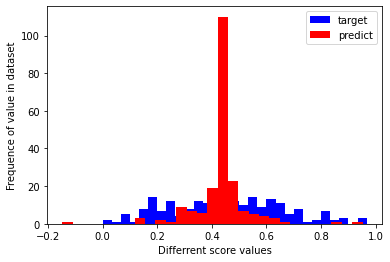

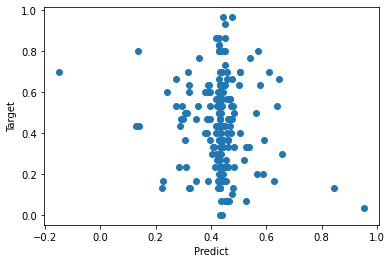

TOPIC_#34
Report:
mean_squared_error: 0.048
mean_absolute_error: 0.1819
r2_score -0.0514
pearsonr_corr: 0.0534, pearsonr_p: 0.4489
spearman_corr: 0.0412, spearman_p: 0.5592



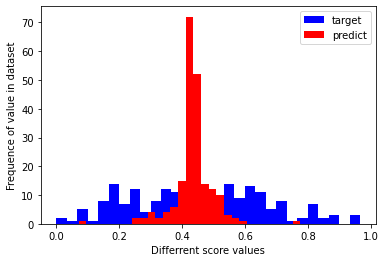

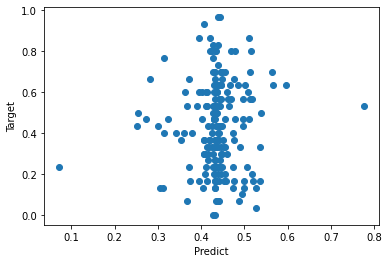

TOPIC_#35
Report:
mean_squared_error: 0.05
mean_absolute_error: 0.1845
r2_score -0.093
pearsonr_corr: 0.0209, pearsonr_p: 0.7673
spearman_corr: 0.0203, spearman_p: 0.7735



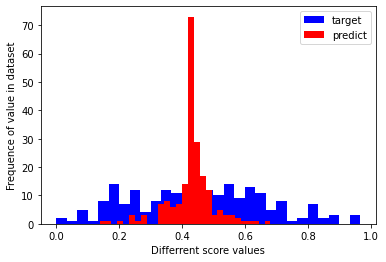

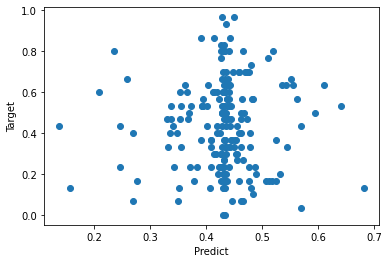

TOPIC_#36
Report:
mean_squared_error: 0.0535
mean_absolute_error: 0.19
r2_score -0.1716
pearsonr_corr: -0.0256, pearsonr_p: 0.7174
spearman_corr: 0.0167, spearman_p: 0.8132



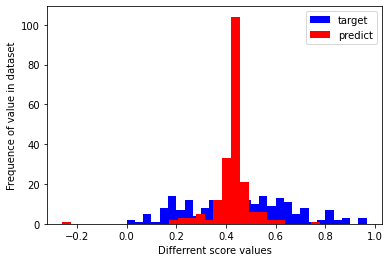

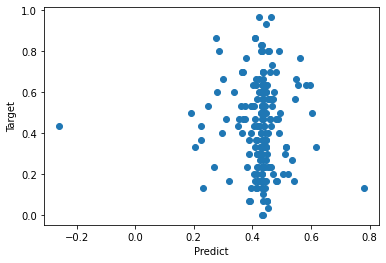

TOPIC_#37
Report:
mean_squared_error: 0.0477
mean_absolute_error: 0.1813
r2_score -0.0429
pearsonr_corr: 0.0998, pearsonr_p: 0.1568
spearman_corr: 0.0603, spearman_p: 0.393



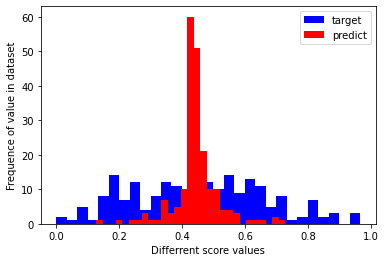

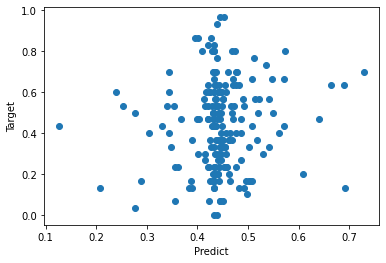

TOPIC_#38
Report:
mean_squared_error: 0.0451
mean_absolute_error: 0.1753
r2_score 0.0124
pearsonr_corr: 0.1679, pearsonr_p: 0.0166
spearman_corr: 0.1111, spearman_p: 0.1145



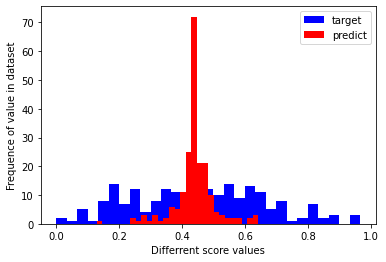

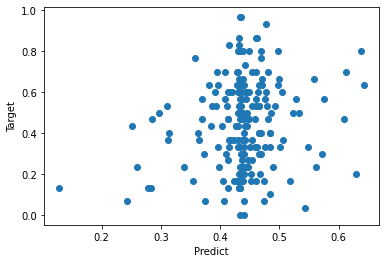

TOPIC_#39
Report:
mean_squared_error: 0.0485
mean_absolute_error: 0.1841
r2_score -0.0607
pearsonr_corr: 0.0289, pearsonr_p: 0.6821
spearman_corr: 0.0059, spearman_p: 0.9329



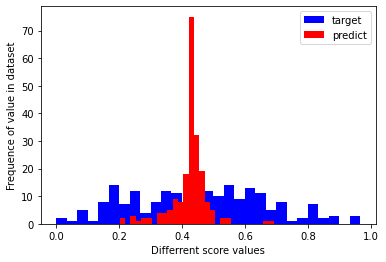

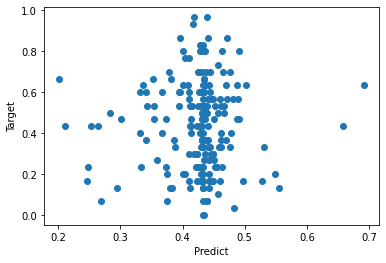

In [180]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=5, ngram_range=(1, 1), stop_words=stop_words
)
for topic, topic_inds in indicies.items():
    print(topic.upper())
    X_train_vec = tf_vectorizer.fit_transform(train["clear_text_by_user"])
    X_test_vec = tf_vectorizer.transform(test["clear_text_by_user"])
    rid = Ridge()
    rid.fit(X_train_vec[:,topic_inds], train.diener_score)
    predicted_y = rid.predict(X_test_vec[:,topic_inds])
    get_metrics(test.diener_score, predicted_y)
    plot_two_distributions(test.diener_score, predicted_y )

In [ ]:
# best topic #4, lets check words 

In [186]:
print(words["topic_#4"].tolist())

['просто', 'очень', 'знаю', 'могу', 'пока', 'немного', 'вроде', 'хочу', 'думаю', 'завтра', 'буду', 'поэтому', 'поняла', 'хотела', 'хочешь', 'думала', 'сколько', 'понимаю', 'время', 'это', 'плохо', 'пожалуйста', 'можешь', 'нужно', 'кошечка', 'рр', 'минут', 'скорее', 'метро', 'сделать', 'дома', 'правда', 'кстати', 'день', 'нормально', 'именно', 'наверно', 'целом', 'ррр', 'нравится', 'сделала', 'хочется', 'смотрю', 'часа', 'честно', 'помню', 'отлично', 'прости', 'пару', 'решила']


TOPIC_#0
Report:
mean_squared_error: 0.0391
mean_absolute_error: 0.1585
r2_score -0.1275
pearsonr_corr: 0.0142, pearsonr_p: 0.841
spearman_corr: 0.0402, spearman_p: 0.5692



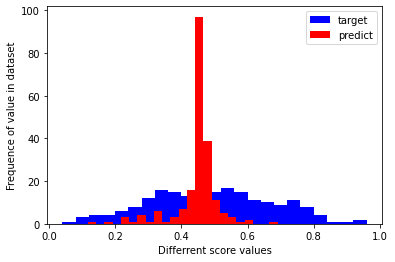

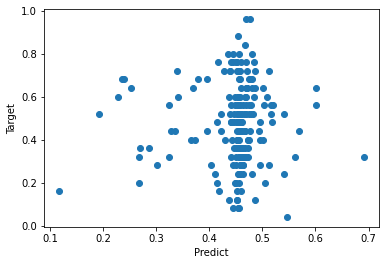

TOPIC_#1
Report:
mean_squared_error: 0.037
mean_absolute_error: 0.1582
r2_score -0.0653
pearsonr_corr: 0.076, pearsonr_p: 0.2814
spearman_corr: 0.1004, spearman_p: 0.1539



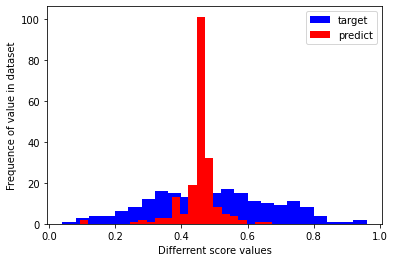

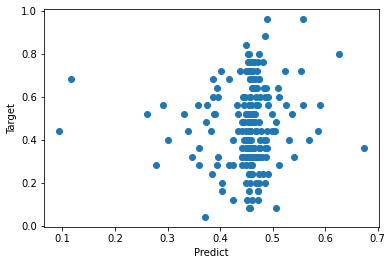

TOPIC_#2
Report:
mean_squared_error: 0.0392
mean_absolute_error: 0.1622
r2_score -0.1288
pearsonr_corr: -0.0095, pearsonr_p: 0.8925
spearman_corr: -0.0276, spearman_p: 0.696



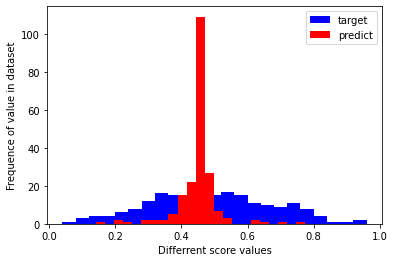

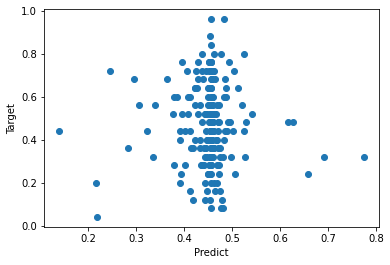

TOPIC_#3
Report:
mean_squared_error: 0.0401
mean_absolute_error: 0.1613
r2_score -0.1555
pearsonr_corr: -0.0362, pearsonr_p: 0.6083
spearman_corr: -0.0354, spearman_p: 0.6162



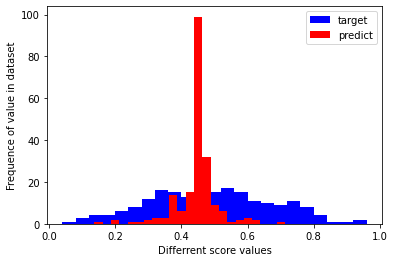

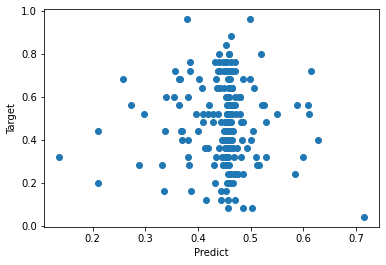

TOPIC_#4
Report:
mean_squared_error: 0.0357
mean_absolute_error: 0.1535
r2_score -0.0285
pearsonr_corr: 0.2253, pearsonr_p: 0.0012
spearman_corr: 0.1242, spearman_p: 0.0776



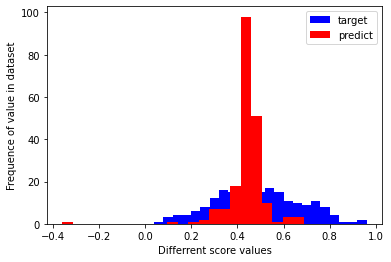

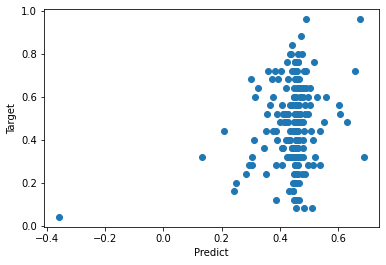

TOPIC_#5
Report:
mean_squared_error: 0.0375
mean_absolute_error: 0.1563
r2_score -0.0808
pearsonr_corr: 0.1029, pearsonr_p: 0.1439
spearman_corr: 0.103, spearman_p: 0.1438



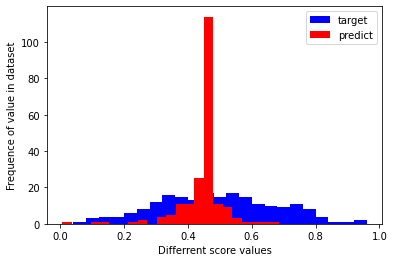

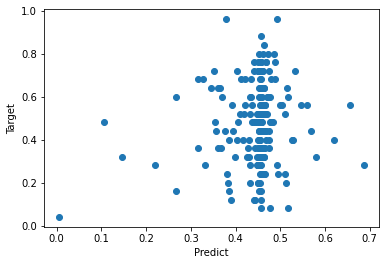

TOPIC_#6
Report:
mean_squared_error: 0.0413
mean_absolute_error: 0.1604
r2_score -0.1897
pearsonr_corr: -0.0974, pearsonr_p: 0.167
spearman_corr: -0.0688, spearman_p: 0.3295



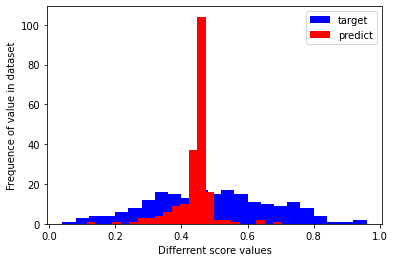

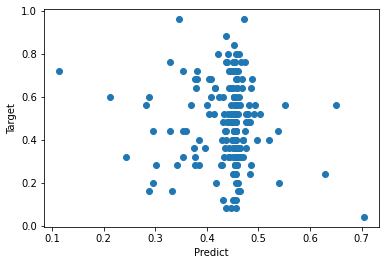

TOPIC_#7
Report:
mean_squared_error: 0.0389
mean_absolute_error: 0.1605
r2_score -0.1218
pearsonr_corr: -0.0196, pearsonr_p: 0.7811
spearman_corr: -0.0728, spearman_p: 0.3021



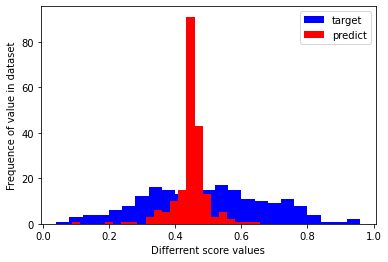

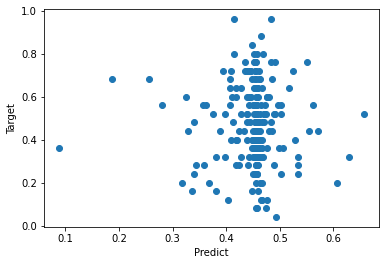

TOPIC_#8
Report:
mean_squared_error: 0.037
mean_absolute_error: 0.1552
r2_score -0.0657
pearsonr_corr: 0.0535, pearsonr_p: 0.4485
spearman_corr: 0.1293, spearman_p: 0.066



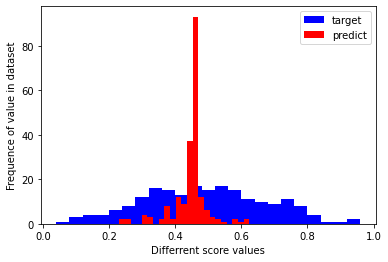

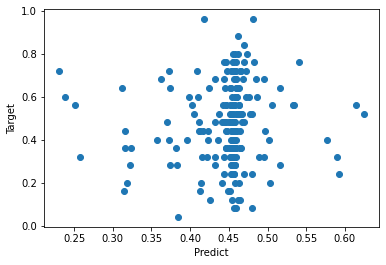

TOPIC_#9
Report:
mean_squared_error: 0.0391
mean_absolute_error: 0.1608
r2_score -0.126
pearsonr_corr: -0.0026, pearsonr_p: 0.9703
spearman_corr: 0.0032, spearman_p: 0.9639



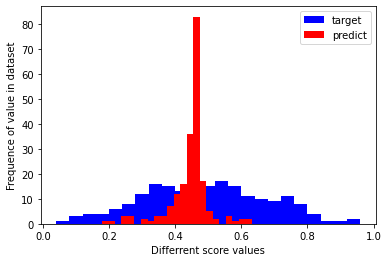

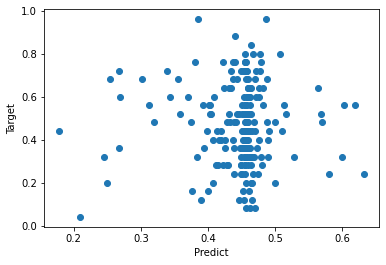

TOPIC_#10
Report:
mean_squared_error: 0.0382
mean_absolute_error: 0.1596
r2_score -0.1008
pearsonr_corr: 0.0972, pearsonr_p: 0.1675
spearman_corr: 0.1046, spearman_p: 0.1376



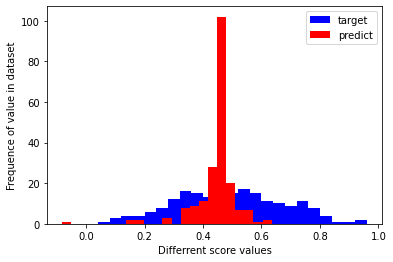

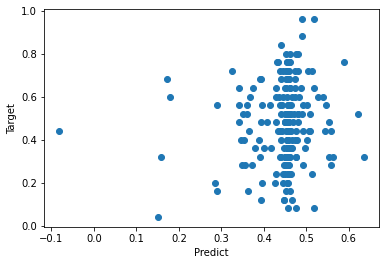

TOPIC_#11
Report:
mean_squared_error: 0.0438
mean_absolute_error: 0.1655
r2_score -0.2625
pearsonr_corr: -0.0352, pearsonr_p: 0.6184
spearman_corr: 0.0262, spearman_p: 0.7109



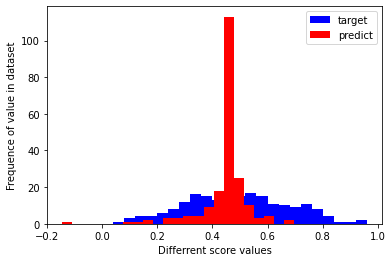

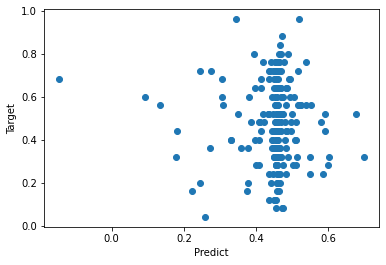

TOPIC_#12
Report:
mean_squared_error: 0.0357
mean_absolute_error: 0.1534
r2_score -0.0275
pearsonr_corr: 0.1281, pearsonr_p: 0.0685
spearman_corr: 0.1005, spearman_p: 0.1536



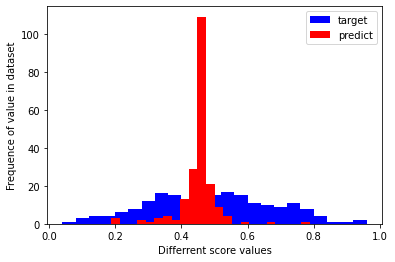

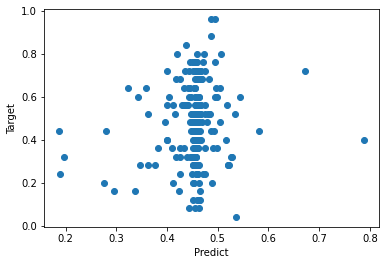

TOPIC_#13
Report:
mean_squared_error: 0.0379
mean_absolute_error: 0.1562
r2_score -0.0902
pearsonr_corr: 0.0514, pearsonr_p: 0.4662
spearman_corr: -0.0108, spearman_p: 0.8786



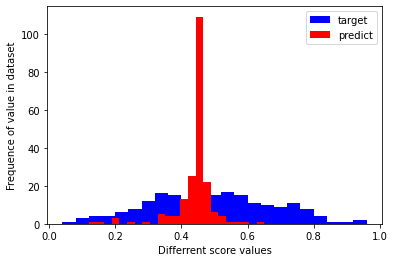

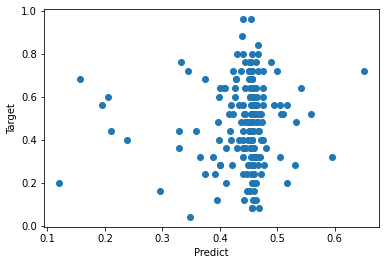

TOPIC_#14
Report:
mean_squared_error: 0.0386
mean_absolute_error: 0.1589
r2_score -0.1131
pearsonr_corr: 0.1399, pearsonr_p: 0.0466
spearman_corr: 0.0742, spearman_p: 0.293



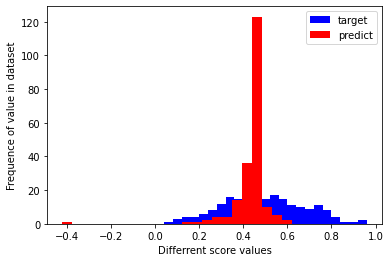

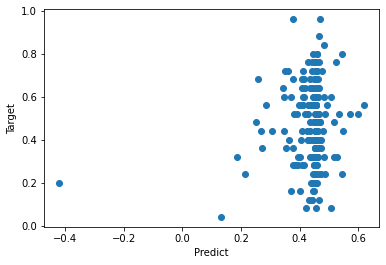

TOPIC_#15
Report:
mean_squared_error: 0.0433
mean_absolute_error: 0.1666
r2_score -0.2469
pearsonr_corr: -0.0339, pearsonr_p: 0.6311
spearman_corr: -0.0228, spearman_p: 0.7465



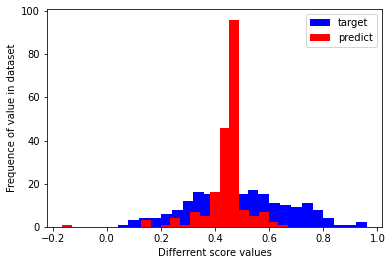

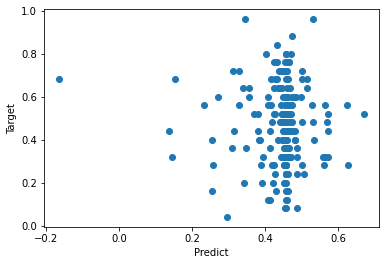

TOPIC_#16
Report:
mean_squared_error: 0.0382
mean_absolute_error: 0.1597
r2_score -0.1
pearsonr_corr: 0.1237, pearsonr_p: 0.0788
spearman_corr: 0.1127, spearman_p: 0.1094



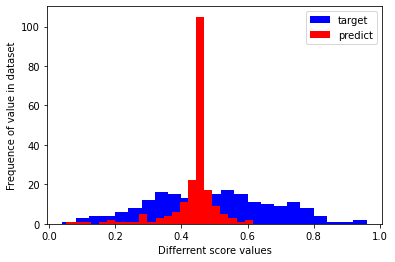

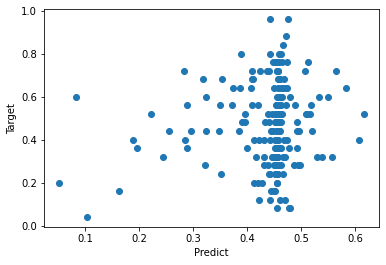

TOPIC_#17
Report:
mean_squared_error: 0.0388
mean_absolute_error: 0.1575
r2_score -0.1185
pearsonr_corr: 0.0175, pearsonr_p: 0.804
spearman_corr: -0.0073, spearman_p: 0.9176



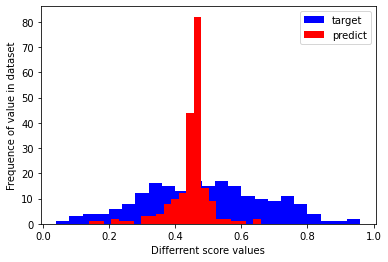

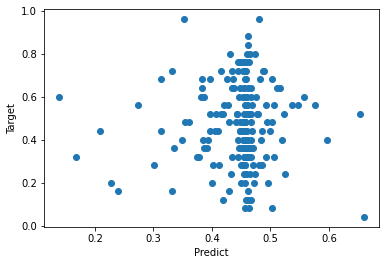

TOPIC_#18
Report:
mean_squared_error: 0.0391
mean_absolute_error: 0.1612
r2_score -0.127
pearsonr_corr: -0.0124, pearsonr_p: 0.8607
spearman_corr: 0.0494, spearman_p: 0.4844



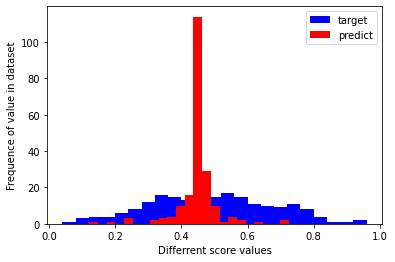

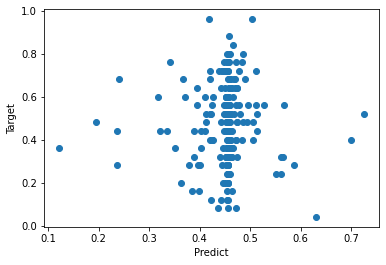

TOPIC_#19
Report:
mean_squared_error: 0.0421
mean_absolute_error: 0.1661
r2_score -0.2124
pearsonr_corr: 0.0944, pearsonr_p: 0.1801
spearman_corr: 0.0895, spearman_p: 0.2041



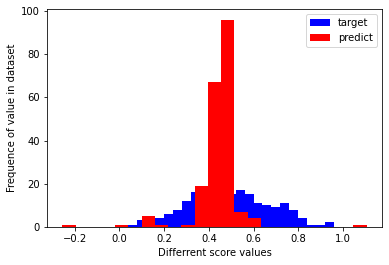

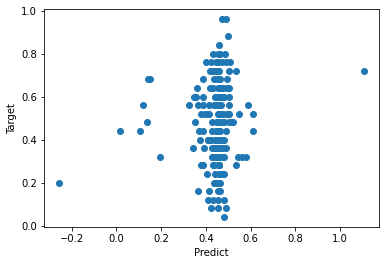

TOPIC_#20
Report:
mean_squared_error: 0.0415
mean_absolute_error: 0.1615
r2_score -0.1945
pearsonr_corr: -0.0264, pearsonr_p: 0.708
spearman_corr: 0.0117, spearman_p: 0.8684



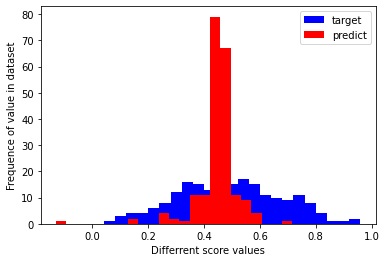

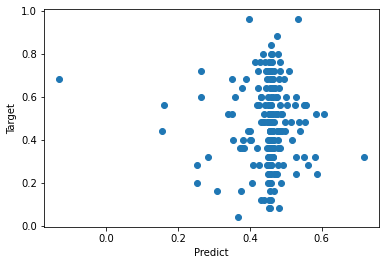

TOPIC_#21
Report:
mean_squared_error: 0.0358
mean_absolute_error: 0.153
r2_score -0.0324
pearsonr_corr: 0.1441, pearsonr_p: 0.0403
spearman_corr: 0.0347, spearman_p: 0.623



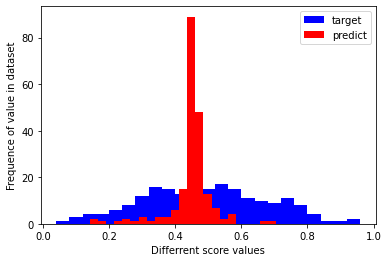

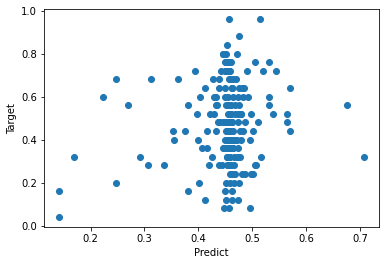

TOPIC_#22
Report:
mean_squared_error: 0.0396
mean_absolute_error: 0.16
r2_score -0.1419
pearsonr_corr: 0.0268, pearsonr_p: 0.7046
spearman_corr: 0.0503, spearman_p: 0.4758



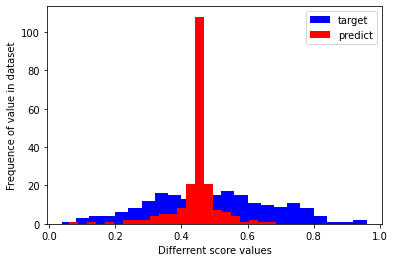

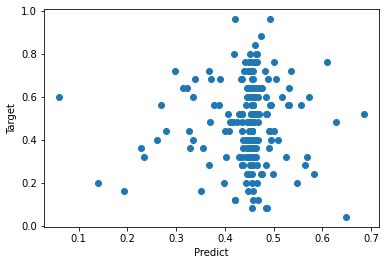

TOPIC_#23
Report:
mean_squared_error: 0.0376
mean_absolute_error: 0.1567
r2_score -0.0842
pearsonr_corr: 0.067, pearsonr_p: 0.3426
spearman_corr: 0.025, spearman_p: 0.7229



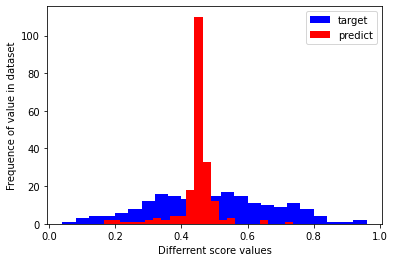

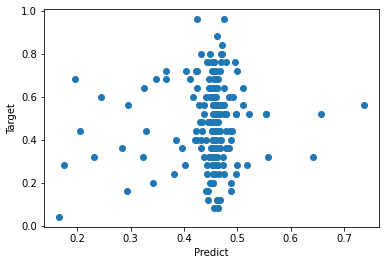

TOPIC_#24
Report:
mean_squared_error: 0.0398
mean_absolute_error: 0.1598
r2_score -0.1456
pearsonr_corr: 0.009, pearsonr_p: 0.8982
spearman_corr: -0.0432, spearman_p: 0.5405



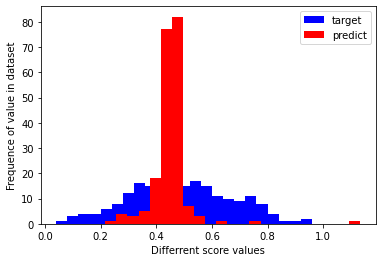

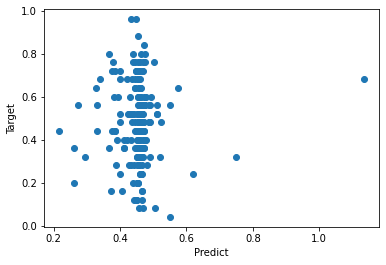

TOPIC_#25
Report:
mean_squared_error: 0.04
mean_absolute_error: 0.1612
r2_score -0.1528
pearsonr_corr: 0.0029, pearsonr_p: 0.9673
spearman_corr: -0.0107, spearman_p: 0.8797



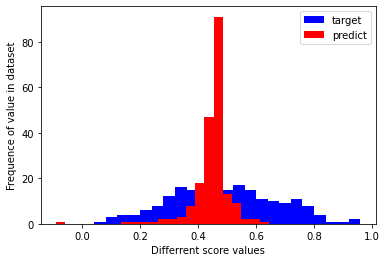

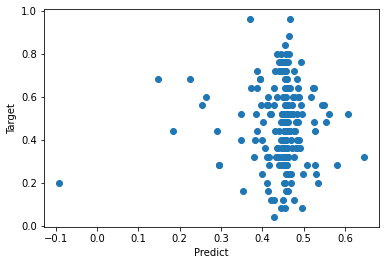

TOPIC_#26
Report:
mean_squared_error: 0.0366
mean_absolute_error: 0.1528
r2_score -0.0549
pearsonr_corr: 0.1004, pearsonr_p: 0.1542
spearman_corr: 0.1764, spearman_p: 0.0118



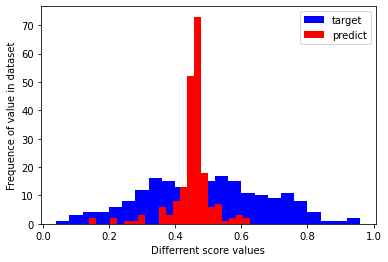

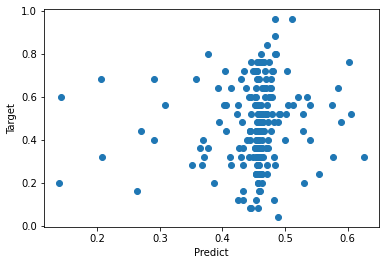

TOPIC_#27
Report:
mean_squared_error: 0.0385
mean_absolute_error: 0.158
r2_score -0.1097
pearsonr_corr: -0.0262, pearsonr_p: 0.7104
spearman_corr: 0.1284, spearman_p: 0.0679



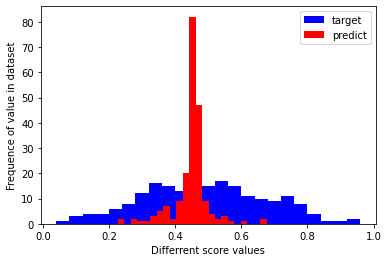

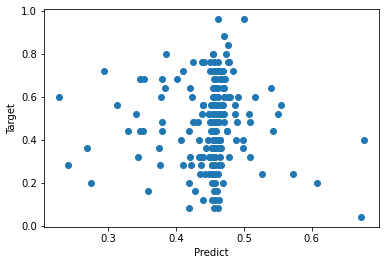

TOPIC_#28
Report:
mean_squared_error: 0.0416
mean_absolute_error: 0.1604
r2_score -0.1993
pearsonr_corr: -0.0026, pearsonr_p: 0.9711
spearman_corr: 0.0671, spearman_p: 0.3413



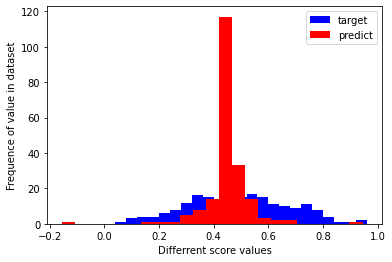

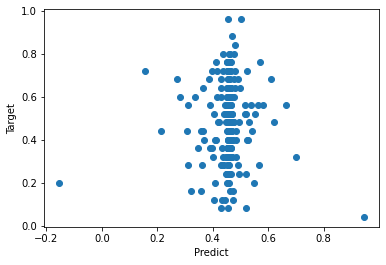

TOPIC_#29
Report:
mean_squared_error: 0.0373
mean_absolute_error: 0.1565
r2_score -0.0748
pearsonr_corr: 0.1222, pearsonr_p: 0.0824
spearman_corr: 0.1331, spearman_p: 0.0584



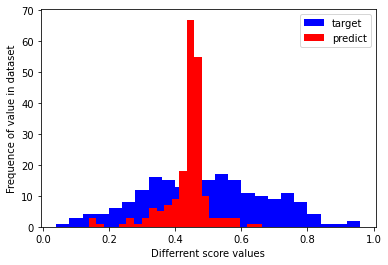

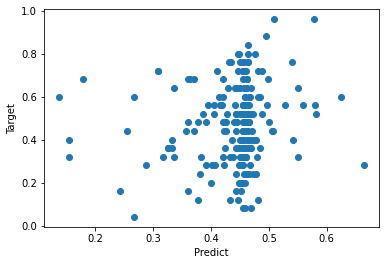

TOPIC_#30
Report:
mean_squared_error: 0.0396
mean_absolute_error: 0.1609
r2_score -0.1401
pearsonr_corr: 0.1169, pearsonr_p: 0.0968
spearman_corr: 0.0269, spearman_p: 0.7029



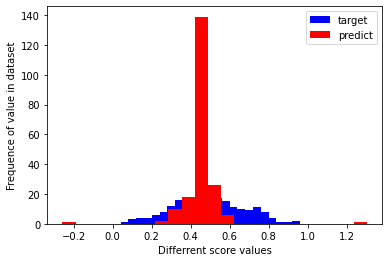

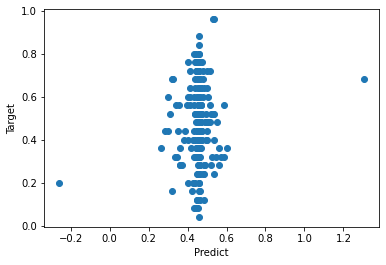

TOPIC_#31
Report:
mean_squared_error: 0.0348
mean_absolute_error: 0.1504
r2_score -0.0011
pearsonr_corr: 0.1785, pearsonr_p: 0.0108
spearman_corr: 0.2109, spearman_p: 0.0025



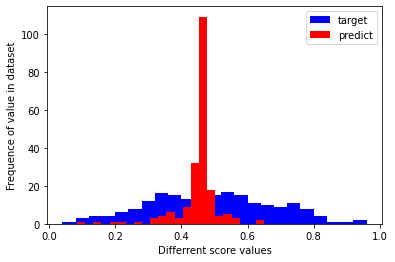

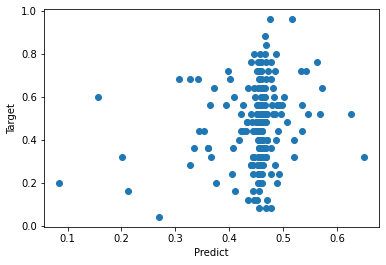

TOPIC_#32
Report:
mean_squared_error: 0.037
mean_absolute_error: 0.1557
r2_score -0.0665
pearsonr_corr: 0.0742, pearsonr_p: 0.2928
spearman_corr: 0.0641, spearman_p: 0.3639



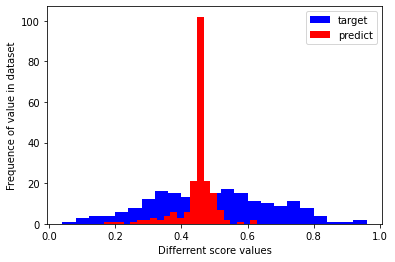

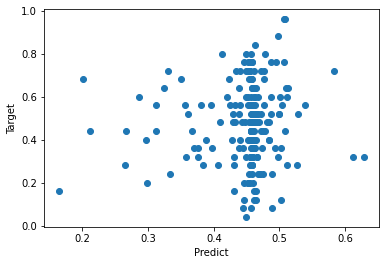

TOPIC_#33
Report:
mean_squared_error: 0.0401
mean_absolute_error: 0.1587
r2_score -0.1558
pearsonr_corr: -0.0555, pearsonr_p: 0.4318
spearman_corr: 0.0241, spearman_p: 0.7327



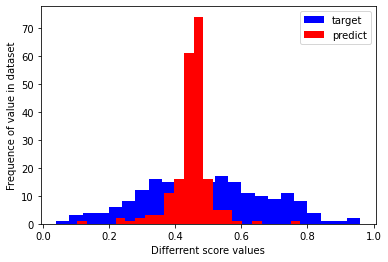

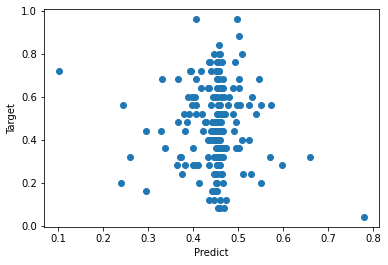

TOPIC_#34
Report:
mean_squared_error: 0.037
mean_absolute_error: 0.1566
r2_score -0.0653
pearsonr_corr: 0.0316, pearsonr_p: 0.654
spearman_corr: -0.0397, spearman_p: 0.5736



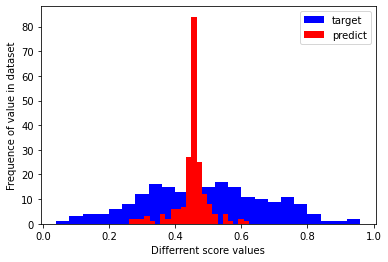

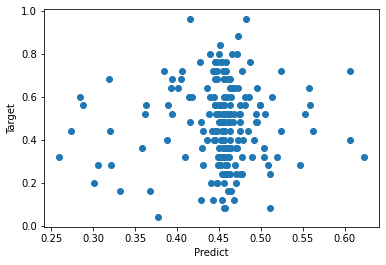

TOPIC_#35
Report:
mean_squared_error: 0.0414
mean_absolute_error: 0.1667
r2_score -0.1915
pearsonr_corr: -0.0319, pearsonr_p: 0.651
spearman_corr: -0.0542, spearman_p: 0.4425



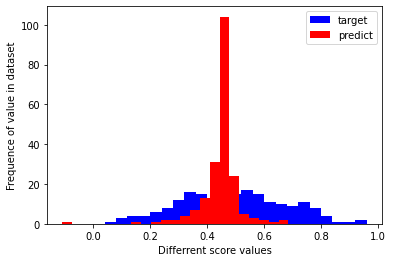

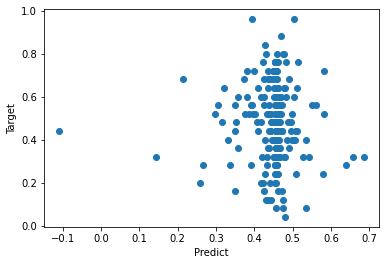

TOPIC_#36
Report:
mean_squared_error: 0.0373
mean_absolute_error: 0.1581
r2_score -0.0729
pearsonr_corr: 0.07, pearsonr_p: 0.3207
spearman_corr: 0.0849, spearman_p: 0.2284



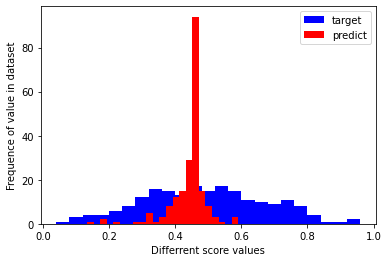

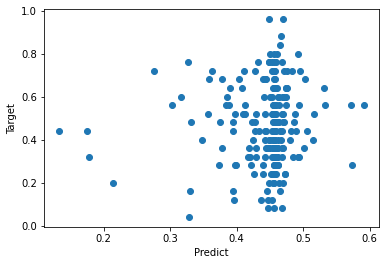

TOPIC_#37
Report:
mean_squared_error: 0.0372
mean_absolute_error: 0.1592
r2_score -0.07
pearsonr_corr: 0.0775, pearsonr_p: 0.2715
spearman_corr: 0.0807, spearman_p: 0.2523



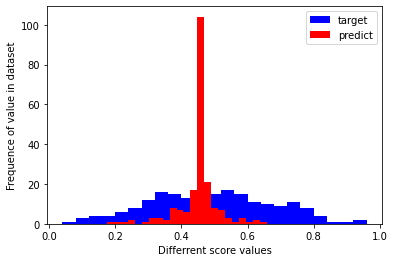

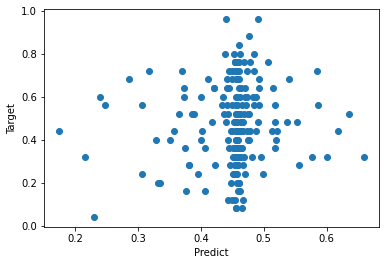

TOPIC_#38
Report:
mean_squared_error: 0.0396
mean_absolute_error: 0.1589
r2_score -0.142
pearsonr_corr: 0.0132, pearsonr_p: 0.852
spearman_corr: 0.0307, spearman_p: 0.6634



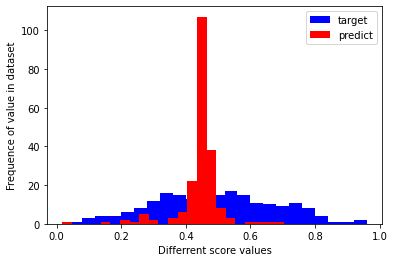

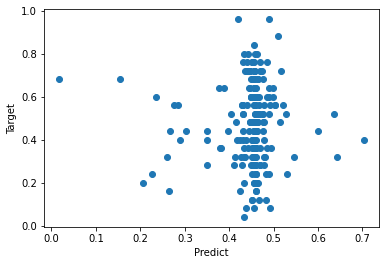

TOPIC_#39
Report:
mean_squared_error: 0.0431
mean_absolute_error: 0.1661
r2_score -0.24
pearsonr_corr: -0.0162, pearsonr_p: 0.8185
spearman_corr: 0.0005, spearman_p: 0.9946



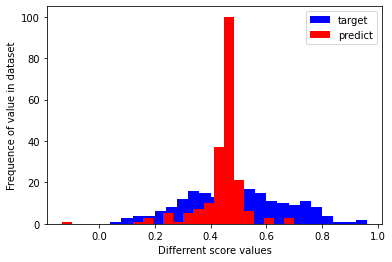

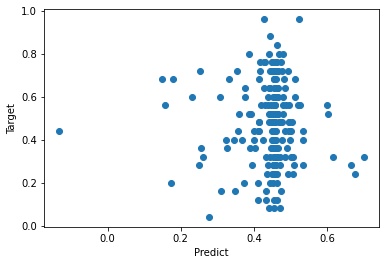

In [181]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=5, ngram_range=(1, 1), stop_words=stop_words
)
for topic, topic_inds in indicies.items():
    print(topic.upper())
    X_train_vec = tf_vectorizer.fit_transform(train["clear_text_by_user"])
    X_test_vec = tf_vectorizer.transform(test["clear_text_by_user"])
    rid = Ridge()
    rid.fit(X_train_vec[:,topic_inds], train.who_score)
    predicted_y = rid.predict(X_test_vec[:,topic_inds])
    get_metrics(test.who_score, predicted_y)
    plot_two_distributions(test.who_score, predicted_y )

In [159]:
from scripts.metrics import get_metrics, plot_two_distributions
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

Report:
mean_squared_error: 0.0509
mean_absolute_error: 0.1867
r2_score -0.1132
pearsonr_corr: 0.1557, pearsonr_p: 0.0265
spearman_corr: 0.1164, spearman_p: 0.0982



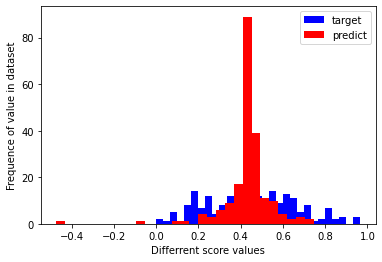

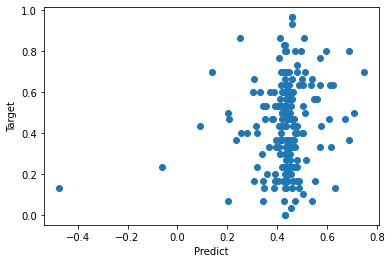

In [160]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=5, ngram_range=(1, 1), stop_words=stop_words,
)
X_train_vec = tf_vectorizer.fit_transform(train.clear_text_by_user)
X_test_vec = tf_vectorizer.transform(test.clear_text_by_user)
rid = Ridge()
rid.fit(X_train_vec, train.diener_score)
predicted_y = rid.predict(X_test_vec)
get_metrics(test.diener_score, predicted_y)
plot_two_distributions(test.diener_score, predicted_y,)

In [2]:
# simple pipeline based on CountVectorizer and TfidfVectorizer with stop words to check if messages can describe the user profile

In [3]:
# who_score

Report:
mean_squared_error: 0.0391
mean_absolute_error: 0.1607
r2_score -0.1269
pearsonr_corr: 0.1931, pearsonr_p: 0.0058
spearman_corr: 0.1989, spearman_p: 0.0045



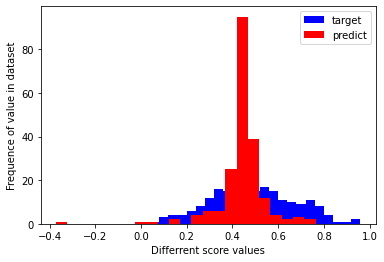

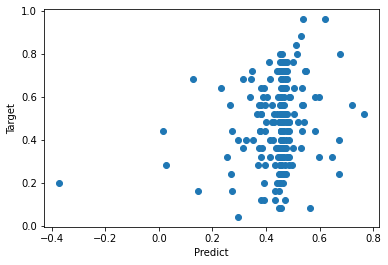

In [154]:
count_vec = CountVectorizer(
    max_df=0.95, min_df=5, ngram_range=(1, 1), stop_words=stop_words
)
X_train_vec = count_vec.fit_transform(train.clear_text_by_user)
X_test_vec = count_vec.transform(test.clear_text_by_user)
rid = Ridge()
rid.fit(X_train_vec, train.who_score)
predicted_y = rid.predict(X_test_vec)
get_metrics(test.who_score, predicted_y)
plot_two_distributions(test.who_score, predicted_y,)

Report:
mean_squared_error: 0.033
mean_absolute_error: 0.1504
r2_score 0.0484
pearsonr_corr: 0.238, pearsonr_p: 0.0006
spearman_corr: 0.1797, spearman_p: 0.0103



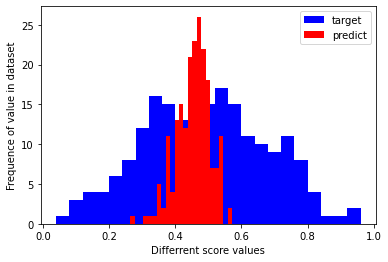

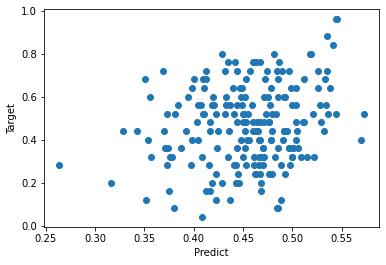

In [156]:
tf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5, ngram_range=(1, 1), stop_words=stop_words
)
X_train_vec = tf_vectorizer.fit_transform(train.clear_text_by_user)
X_test_vec = tf_vectorizer.transform(test.clear_text_by_user)
rid = Ridge()
rid.fit(X_train_vec, train.who_score)
predicted_y = rid.predict(X_test_vec)
get_metrics(test.who_score, predicted_y)
plot_two_distributions(test.who_score, predicted_y)

In [ ]:
# diener_score

Report:
mean_squared_error: 0.0341
mean_absolute_error: 0.1499
r2_score 0.0169
pearsonr_corr: 0.2624, pearsonr_p: 0.0002
spearman_corr: 0.2414, spearman_p: 0.0005



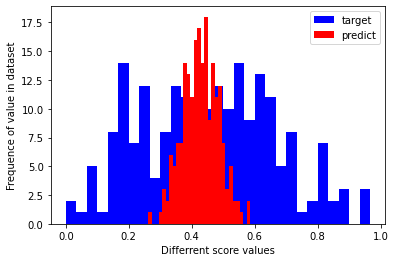

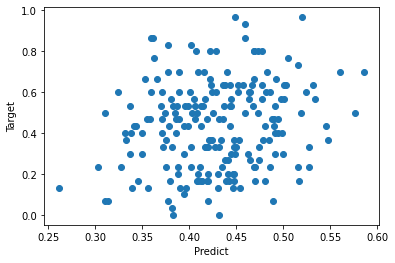

In [157]:
tf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5, ngram_range=(1, 1), stop_words=stop_words
)
X_train_vec = tf_vectorizer.fit_transform(train.clear_text_by_user)
X_test_vec = tf_vectorizer.transform(test.clear_text_by_user)
rid = Ridge()
rid.fit(X_train_vec, train.diener_score)
predicted_y = rid.predict(X_test_vec)
get_metrics(test.who_score, predicted_y)
plot_two_distributions(test.diener_score, predicted_y)

In [4]:
# diener_score with feature selection using matrix correlation with target
# left only features that have correlation > quantile(0.5) = mean 

(450, 59048)
29583
Report:
mean_squared_error: 0.0444
mean_absolute_error: 0.1756
r2_score 0.0284
pearsonr_corr: 0.1862, pearsonr_p: 0.0078
spearman_corr: 0.1915, spearman_p: 0.0062



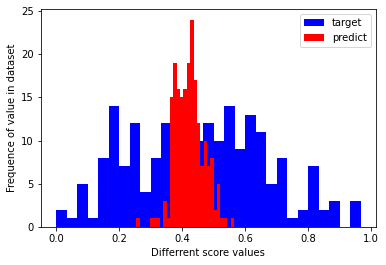

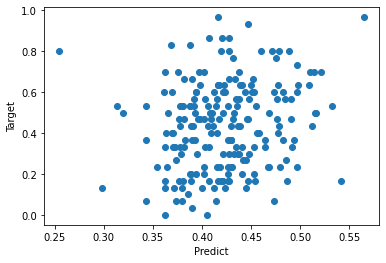

In [162]:
y_train = train.diener_score
y_test = test.diener_score

vectorizer = TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize,
            )

X_train_join_tf = vectorizer.fit_transform(train.clear_text_by_user)
X_test_join_tf = vectorizer.transform(test.clear_text_by_user)
print("n smaples x n_featutes", X_train_join_tf.shape)

correlations = np.corrcoef(np.array(X_train_join_tf.todense().transpose()), y_train)
selected_feateres = []
right_quant = np.quantile(correlations[:,-1], 0.5)
left_quant = np.quantile(correlations[:,-1], 0.001)

for index, v in enumerate(correlations[:,-1].tolist()):
    if (v > right_quant and v < 1 and index < X_train_join_tf.shape[1]) \
        or (v < left_quant and v < 1 and index < X_train_join_tf.shape[1]):
        selected_feateres.append(index)
print("n features after selecting", len(selected_feateres))

rm = Ridge()
rm.fit(X_train_join_tf[:,selected_feateres] , y_train)
predicted_y = rm.predict(X_test_join_tf[:, selected_feateres])
get_metrics(y_test, predicted_y)
plot_two_distributions(y_test, predicted_y)

In [ ]:
# who score with feature selection using matrix correlation with target
# left only features that have correlation > quantile(0.5) = mean

(450, 59048)
59049
29584
Report:
mean_squared_error: 0.0332
mean_absolute_error: 0.1495
r2_score 0.044
pearsonr_corr: 0.2428, pearsonr_p: 0.0005
spearman_corr: 0.1915, spearman_p: 0.0062



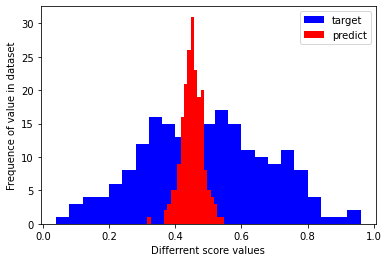

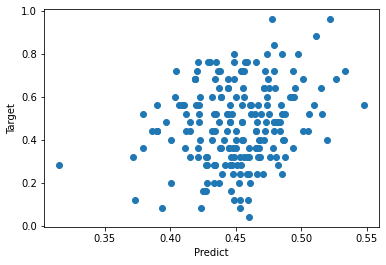

In [176]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
y_train = train.who_score
y_test = test.who_score

vectorizer = TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize,
            )

X_train_join_tf = vectorizer.fit_transform(train.clear_text_by_user)
X_test_join_tf = vectorizer.transform(test.clear_text_by_user)
print(X_train_join_tf.shape)

correlations = np.corrcoef(np.array(X_train_join_tf.todense().transpose()), y_train)
selected_feateres = []
quantile_08 = np.quantile(correlations[:-1,-1], 0.5)
quantile_02 = np.quantile(correlations[:-1,-1], 0.001)
print(len(correlations[:,-1].tolist()))

for index, v in enumerate(correlations[:,-1].tolist()):
    if (v > quantile_08 and v < 1 and index < X_train_join_tf.shape[1]) \
        or (v < quantile_02 and v < 1 and index < X_train_join_tf.shape[1]):
        selected_feateres.append(index)
print(len(selected_feateres))

rm = Ridge()
rm.fit(X_train_join_tf[:,selected_feateres] , y_train)
predicted_y = rm.predict(X_test_join_tf[:, selected_feateres])
get_metrics(y_test, predicted_y)
plot_two_distributions(y_test, predicted_y)

In [ ]:
# diener_score with feature selection using matrix correlation with target
# left only features that have correlation > quantile(0.8) or correlation < quantile(0.2) 

(450, 59048)
(59049, 59049)
23620
Report:
mean_squared_error: 0.0454
mean_absolute_error: 0.1783
r2_score 0.0074
pearsonr_corr: 0.1373, pearsonr_p: 0.0507
spearman_corr: 0.1171, spearman_p: 0.0963



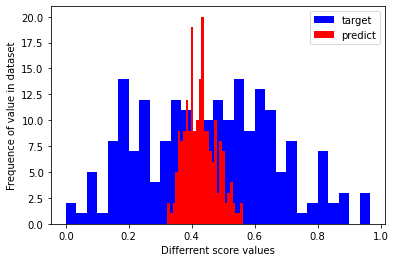

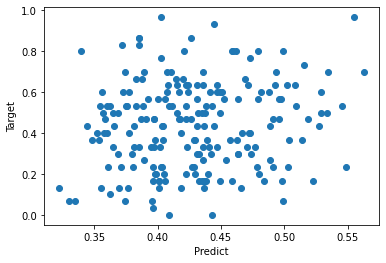

In [175]:
y_train = train.diener_score.values
y_test = test.diener_score.values

vectorizer = TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize,
            )

X_train_join_tf = vectorizer.fit_transform(train.clear_text_by_user)
X_test_join_tf = vectorizer.transform(test.clear_text_by_user)
print(X_train_join_tf.shape)

correlations = np.corrcoef(np.array(X_train_join_tf.todense().transpose()), y_train)
selected_feateres = []
quantile_08 = np.quantile(correlations[:-1,-1], 0.8)
quantile_02 = np.quantile(correlations[:-1,-1], 0.2)
print(correlations.shape)
for index, v in enumerate(correlations[:-1,-1].tolist()):
    if (v > quantile_08 and v < 1) \
        or (v < quantile_02 and v < 1):
        selected_feateres.append(index)
print(len(selected_feateres))

rm = Ridge()
rm.fit(X_train_join_tf[:,selected_feateres] , y_train)
predicted_y = rm.predict(X_test_join_tf[:, selected_feateres])
get_metrics(y_test, predicted_y)
plot_two_distributions(y_test, predicted_y)

In [ ]:
# diener_score with feature selection using matrix correlation with target
# left only features that have correlation > quantile(0.8) or correlation < quantile(0.2) 

(450, 59048)
23619
Report:
mean_squared_error: 0.0334
mean_absolute_error: 0.1489
r2_score 0.0367
pearsonr_corr: 0.2142, pearsonr_p: 0.0022
spearman_corr: 0.1834, spearman_p: 0.0088



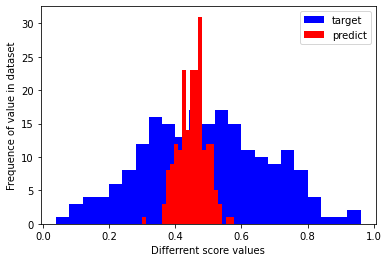

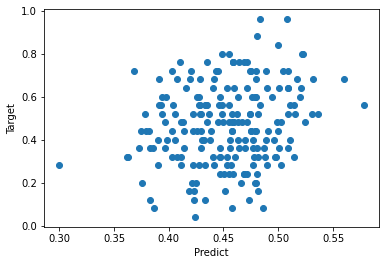

In [164]:
y_train = train.who_score
y_test = test.who_score

vectorizer = TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 1), 
               max_df = 0.95,
               min_df = 5,
               tokenizer = wordpunct_tokenize,
            )

X_train_join_tf = vectorizer.fit_transform(train.clear_text_by_user)
X_test_join_tf = vectorizer.transform(test.clear_text_by_user)
print(X_train_join_tf.shape)

correlations = np.corrcoef(np.array(X_train_join_tf.todense().transpose()), y_train)
selected_feateres = []
quantile_08 = np.quantile(correlations[:,-1], 0.8)
quantile_02 = np.quantile(correlations[:,-1], 0.2)

for index, v in enumerate(correlations[:,-1].tolist()):
    if (v > quantile_08 and v < 1 and index < X_train_join_tf.shape[1]) \
        or (v < quantile_02 and v < 1 and index < X_train_join_tf.shape[1]):
        selected_feateres.append(index)
print(len(selected_feateres))

rm = Ridge()
rm.fit(X_train_join_tf[:,selected_feateres] , y_train)
predicted_y = rm.predict(X_test_join_tf[:, selected_feateres])
get_metrics(y_test, predicted_y)
plot_two_distributions(y_test, predicted_y)

In [ ]:
# if we left people only with low and hight who score, can we predict this? Answer is "No"

In [62]:
base_info_no_test_drop

,Unnamed: 0,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,...,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,is_test_sample,3_months_text,text_by_user
4,7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,0.72,4.0,...,0.633333,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,False,"[Привет, Как ты?, Не особо, хвосты намечаются,...","Привет Как ты? Не особо, хвосты намечаются, сп..."
6,10,fb783013-040a-2481-7174-3bf9e0549c29,200269216,4.0,4.0,4.0,5.0,3.0,0.20,6.0,...,0.133333,female,1994.0,"Магистр, сейчас не учусь",NaN,NaN,2018-08-28 13:33:33,False,"[О, спасибо огромное) мне очень приятно что вы...","О, спасибо огромное) мне очень приятно что вы ..."
7,11,fb5ca4c8-b228-2a8e-7489-c8bc9a82e057,305836538,4.0,4.0,4.0,5.0,3.0,0.20,5.0,...,0.333333,NaN,NaN,NaN,NaN,NaN,2018-07-21 22:51:49,False,"[У меня как то наоборот, У меня, Выскочил, ПРЫ...",У меня как то наоборот У меня Выскочил ПРЫЩ Пр...
13,18,f8326bdb-ea08-2293-58a1-a15ddffee26e,313691105,3.0,3.0,3.0,3.0,4.0,0.36,4.0,...,0.266667,female,1995.0,"Неоконченное высшее, учусь",NaN,NaN,2018-07-31 10:25:13,False,"[Нашивки еще не делала, но пару раз вышивала н...","Нашивки еще не делала, но пару раз вышивала на..."
14,20,f847716f-d93d-2ff2-6328-513abb5d302f,101806588,2.0,3.0,3.0,2.0,1.0,0.56,5.0,...,0.266667,NaN,NaN,NaN,NaN,NaN,2018-04-03 21:38:26,False,"[Ты ко скольки пойдёшь?, Дома, А Никитин, Пойд...",Ты ко скольки пойдёшь? Дома А Никитин Пойду Ок...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,2032,051b5d08-a4da-2c2e-7139-5c021ce05d4a,540669219,2.0,4.0,2.0,4.0,5.0,0.32,4.0,...,0.366667,NaN,NaN,NaN,NaN,NaN,2018-03-29 10:04:57,False,"[Немного, 4, Я в курилке уже стою, Что творишь...",Немного 4 Я в курилке уже стою Что творишь? Ау...
1285,2033,0574c52f-84d4-21b1-5447-03f1559a655f,354174379,2.0,1.0,2.0,3.0,0.0,0.68,2.0,...,0.466667,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-30 09:03:00,False,"[хм, хотела в группу, но вышло персонально, оу...","хм, хотела в группу, но вышло персонально оу а..."
1286,2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,0.44,5.0,...,0.333333,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08,False,"[Настя, на всякий случай, если ещё не в курсе,...","Настя, на всякий случай, если ещё не в курсе, ..."
1287,2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,0.40,3.0,...,0.533333,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00,False,"[какие интересные боты в комментах обитают, да...",какие интересные боты в комментах обитают да н...


In [63]:
sample_data = base_info_no_test_drop[
    (base_info_no_test_drop.who_score < 0.35)|(base_info_no_test_drop.who_score > 0.65)
]

In [64]:
sample_data

,Unnamed: 0,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,...,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,is_test_sample,3_months_text,text_by_user
4,7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,0.72,4.0,...,0.633333,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,False,"[Привет, Как ты?, Не особо, хвосты намечаются,...","Привет Как ты? Не особо, хвосты намечаются, сп..."
6,10,fb783013-040a-2481-7174-3bf9e0549c29,200269216,4.0,4.0,4.0,5.0,3.0,0.20,6.0,...,0.133333,female,1994.0,"Магистр, сейчас не учусь",NaN,NaN,2018-08-28 13:33:33,False,"[О, спасибо огромное) мне очень приятно что вы...","О, спасибо огромное) мне очень приятно что вы ..."
7,11,fb5ca4c8-b228-2a8e-7489-c8bc9a82e057,305836538,4.0,4.0,4.0,5.0,3.0,0.20,5.0,...,0.333333,NaN,NaN,NaN,NaN,NaN,2018-07-21 22:51:49,False,"[У меня как то наоборот, У меня, Выскочил, ПРЫ...",У меня как то наоборот У меня Выскочил ПРЫЩ Пр...
15,21,f8a27d50-6834-2362-644b-9c484723fee6,245899682,2.0,1.0,1.0,3.0,1.0,0.68,2.0,...,0.700000,NaN,NaN,NaN,NaN,NaN,2018-03-26 00:19:54,False,"[Ну, Достаточно странная голова, Драсте, Я рис...",Ну Достаточно странная голова Драсте Я рисую И...
19,25,f8fc3278-1306-2926-5aa5-38dd3160fef9,872593126,1.0,1.0,1.0,2.0,1.0,0.76,4.0,...,0.333333,male,1996.0,Неоконченное среднее,NaN,NaN,2018-08-18 00:55:59,False,"[А Тебе моя фотки кросс скидывала?, Ясненько, ...",А Тебе моя фотки кросс скидывала? Ясненько Над...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,2003,010ffc50-0259-2344-7002-c8fea0aa0dc3,374652868,4.0,3.0,5.0,5.0,1.0,0.28,4.0,...,0.533333,NaN,NaN,NaN,NaN,NaN,2018-07-12 16:31:55,False,"[+79167506467, Удалить папку GameGuard из папк...",+79167506467 Удалить папку GameGuard из папки ...
1269,2007,0171b4b8-657a-23fd-6b0b-d7841fa0d4f2,43705965,2.0,1.0,1.0,2.0,2.0,0.68,2.0,...,0.533333,female,1971.0,specialist,worker,married,2018-12-09 20:36:27,False,"[Вокруг тебя сегодня всё кружится,\n\nА все не...","Вокруг тебя сегодня всё кружится,\n\nА все нев..."
1279,2024,04325b0e-5592-27e0-4492-5d8f8caa4d4a,683612077,1.0,1.0,1.0,2.0,2.0,0.72,2.0,...,0.666667,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-21 14:26:01,False,"[Ааааа, классный он :33, Привет), Привет), Как...","Ааааа, классный он :33 Привет) Привет) Как жиз..."
1284,2032,051b5d08-a4da-2c2e-7139-5c021ce05d4a,540669219,2.0,4.0,2.0,4.0,5.0,0.32,4.0,...,0.366667,NaN,NaN,NaN,NaN,NaN,2018-03-29 10:04:57,False,"[Немного, 4, Я в курилке уже стою, Что творишь...",Немного 4 Я в курилке уже стою Что творишь? Ау...


In [65]:
boundary = 200
train_scores = sample_data[:boundary]
test_scores = sample_data[boundary:]

Report:
mean_squared_error: 0.0623
mean_absolute_error: 0.2223
r2_score -15.0011
pearsonr_corr: 0.2765, pearsonr_p: 0.0061
spearman_corr: 0.2885, spearman_p: 0.0042



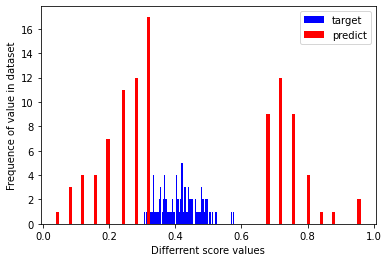

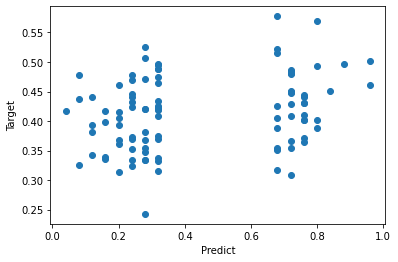

In [67]:
pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1,1), 
               #max_features = 900,
               max_df = 0.95,
               min_df = 10,
               #analyzer = "char"
            )
    ),
    #('pca', TruncatedSVD(500)), 
    ('lr', Ridge())
])

pipe.fit(train_scores.text_by_user, train_scores.who_score)
predicted_y = pipe.predict(test_scores.text_by_user)
get_metrics(predicted_y, test_scores.who_score)
plot_two_distributions(predicted_y, test_scores.who_score)